# Market Campaign Analysis
*Jiazhou (Jay) Pang (April 2024)*

---
This notebook aims to identify and estimate the effect of marketing campaigns by analyzing a marketing dataset made available by ifood.


# Import
---

In [66]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download jackdaoud/marketing-data

!pip install causal-learn
!pip install dowhy

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/jackdaoud/marketing-data
License(s): CC0-1.0
marketing-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [67]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score as shs
from scipy.spatial.distance import cdist

In [68]:
file = "marketing-data.zip"
ZipFile(file, 'r').extractall()

# 1. Data Preprocessing
---

Here I removed null and duplicate entries. The metadata information is shown in the picture below.

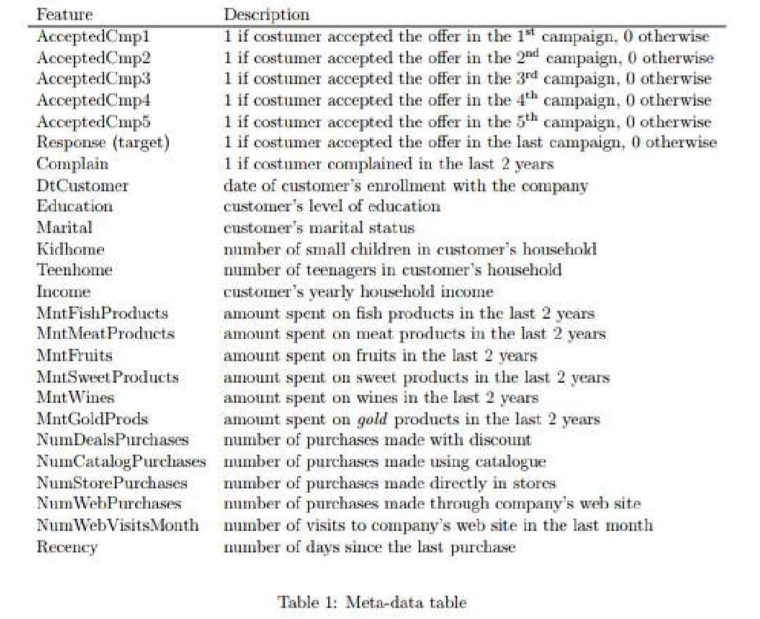

In [69]:
df_initial = pd.read_csv('ifood_df.csv')
df_initial.shape

(2205, 39)

In [70]:
df_initial.isna().sum().sum()

0

The dataset has no null values!

In [71]:
pd.set_option('display.max_columns', None)
df_initial.describe()

Income      Kidhome     Teenhome      Recency     MntWines  \
count    2205.000000  2205.000000  2205.000000  2205.000000  2205.000000   
mean    51622.094785     0.442177     0.506576    49.009070   306.164626   
std     20713.063826     0.537132     0.544380    28.932111   337.493839   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35196.000000     0.000000     0.000000    24.000000    24.000000   
50%     51287.000000     0.000000     0.000000    49.000000   178.000000   
75%     68281.000000     1.000000     1.000000    74.000000   507.000000   
max    113734.000000     2.000000     2.000000    99.000000  1493.000000   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
count  2205.000000      2205.000000      2205.000000       2205.000000   
mean     26.403175       165.312018        37.756463         27.128345   
std      39.784484       217.784507        54.824635         41.130468   
min       0.000000         0.000000         0.000000          0.000000   
25%       2.000000        16.000000         3.000000          1.000000   
50%       8.000000        68.000000        12.000000          8.000000   
75%      33.000000       232.000000        50.000000         34.000000   
max     199.000000      1725.000000       259.000000        262.000000   

       MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count   2205.000000        2205.000000      2205.000000          2205.000000   
mean      44.057143           2.318367         4.100680             2.645351   
std       51.736211           1.886107         2.737424             2.798647   
min        0.000000           0.000000         0.000000             0.000000   
25%        9.000000           1.000000         2.000000             0.000000   
50%       25.000000           2.000000         4.000000             2.000000   
75%       56.000000           3.000000         6.000000             4.000000   
max      321.000000          15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count        2205.000000        2205.000000   2205.000000   2205.000000   
mean            5.823583           5.336961      0.073923      0.074376   
std             3.241796           2.413535      0.261705      0.262442   
min             0.000000           0.000000      0.000000      0.000000   
25%             3.000000           3.000000      0.000000      0.000000   
50%             5.000000           6.000000      0.000000      0.000000   
75%             8.000000           7.000000      0.000000      0.000000   
max            13.000000          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  \
count   2205.000000   2205.000000   2205.000000  2205.000000         2205.0   
mean       0.073016      0.064399      0.013605     0.009070            3.0   
std        0.260222      0.245518      0.115872     0.094827            0.0   
min        0.000000      0.000000      0.000000     0.000000            3.0   
25%        0.000000      0.000000      0.000000     0.000000            3.0   
50%        0.000000      0.000000      0.000000     0.000000            3.0   
75%        0.000000      0.000000      0.000000     0.000000            3.0   
max        1.000000      1.000000      1.000000     1.000000            3.0   

       Z_Revenue    Response          Age  Customer_Days  marital_Divorced  \
count     2205.0  2205.00000  2205.000000    2205.000000       2205.000000   
mean        11.0     0.15102    51.095692    2512.718367          0.104308   
std          0.0     0.35815    11.705801     202.563647          0.305730   
min         11.0     0.00000    24.000000    2159.000000          0.000000   
25%         11.0     0.00000    43.000000    2339.000000          0.000000   
50%         11.0     0.00000    50.000000    2515.000000          0.000000   
75%    

In [72]:
categorical_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
                    'AcceptedCmp5', 'Response', 'Complain', 'education_Basic',
                    'education_Graduation', 'education_2nCycle', 'education_Master',
                    'education_PHD']

In [73]:
df_initial['AcceptedCmpOverall'].sum()
drop_list = ['Z_CostContact', 'Z_Revenue', 'AcceptedCmpOverall']
df_initial = df_initial.drop(drop_list, axis=1)

In [74]:
print(df_initial.duplicated().sum())
df_initial = df_initial.drop_duplicates()

184


The dataset contains 184 duplicate entries.

# 2. EDA
---

## 2.1 Distribution of each Variable

array([[<Axes: title={'center': 'Income'}>,
        <Axes: title={'center': 'Kidhome'}>,
        <Axes: title={'center': 'Teenhome'}>,
        <Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'MntWines'}>,
        <Axes: title={'center': 'MntFruits'}>],
       [<Axes: title={'center': 'MntMeatProducts'}>,
        <Axes: title={'center': 'MntFishProducts'}>,
        <Axes: title={'center': 'MntSweetProducts'}>,
        <Axes: title={'center': 'MntGoldProds'}>,
        <Axes: title={'center': 'NumDealsPurchases'}>,
        <Axes: title={'center': 'NumWebPurchases'}>],
       [<Axes: title={'center': 'NumCatalogPurchases'}>,
        <Axes: title={'center': 'NumStorePurchases'}>,
        <Axes: title={'center': 'NumWebVisitsMonth'}>,
        <Axes: title={'center': 'AcceptedCmp3'}>,
        <Axes: title={'center': 'AcceptedCmp4'}>,
        <Axes: title={'center': 'AcceptedCmp5'}>],
       [<Axes: title={'center': 'AcceptedCmp1'}>,
        <Axes: title={'center': 'Accept

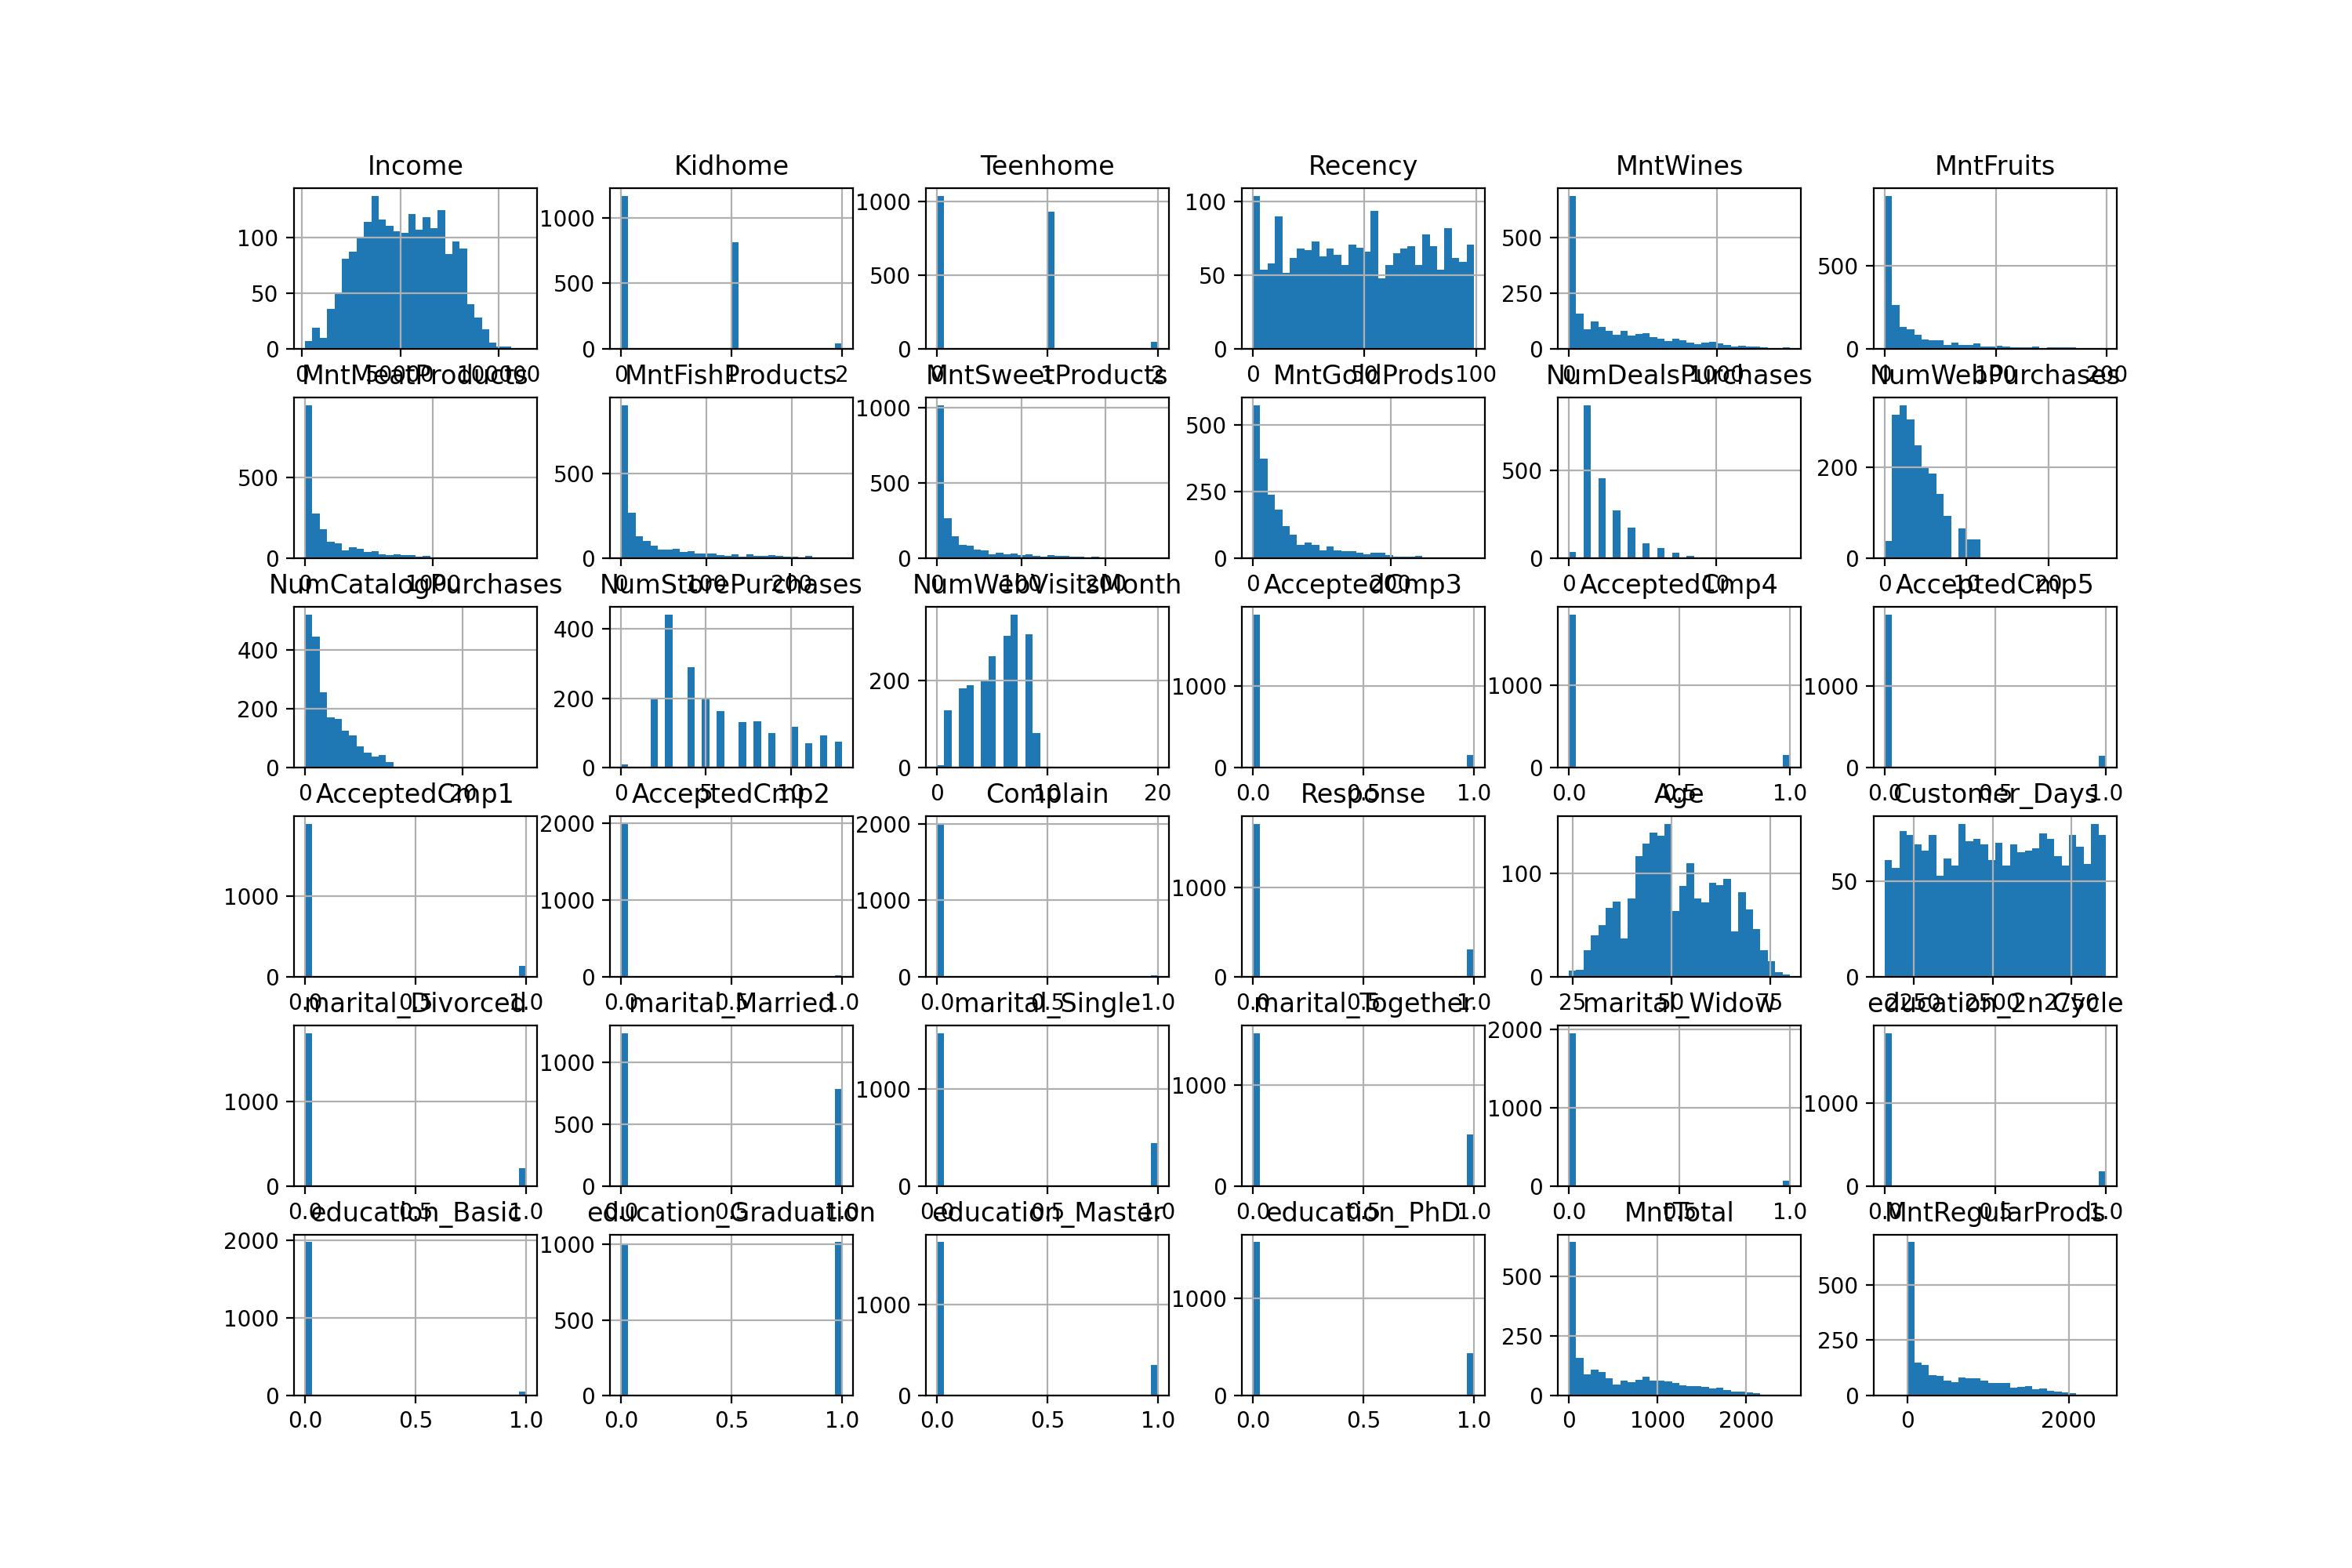

In [75]:
df_initial .hist(bins=30, figsize=(15, 10))

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.


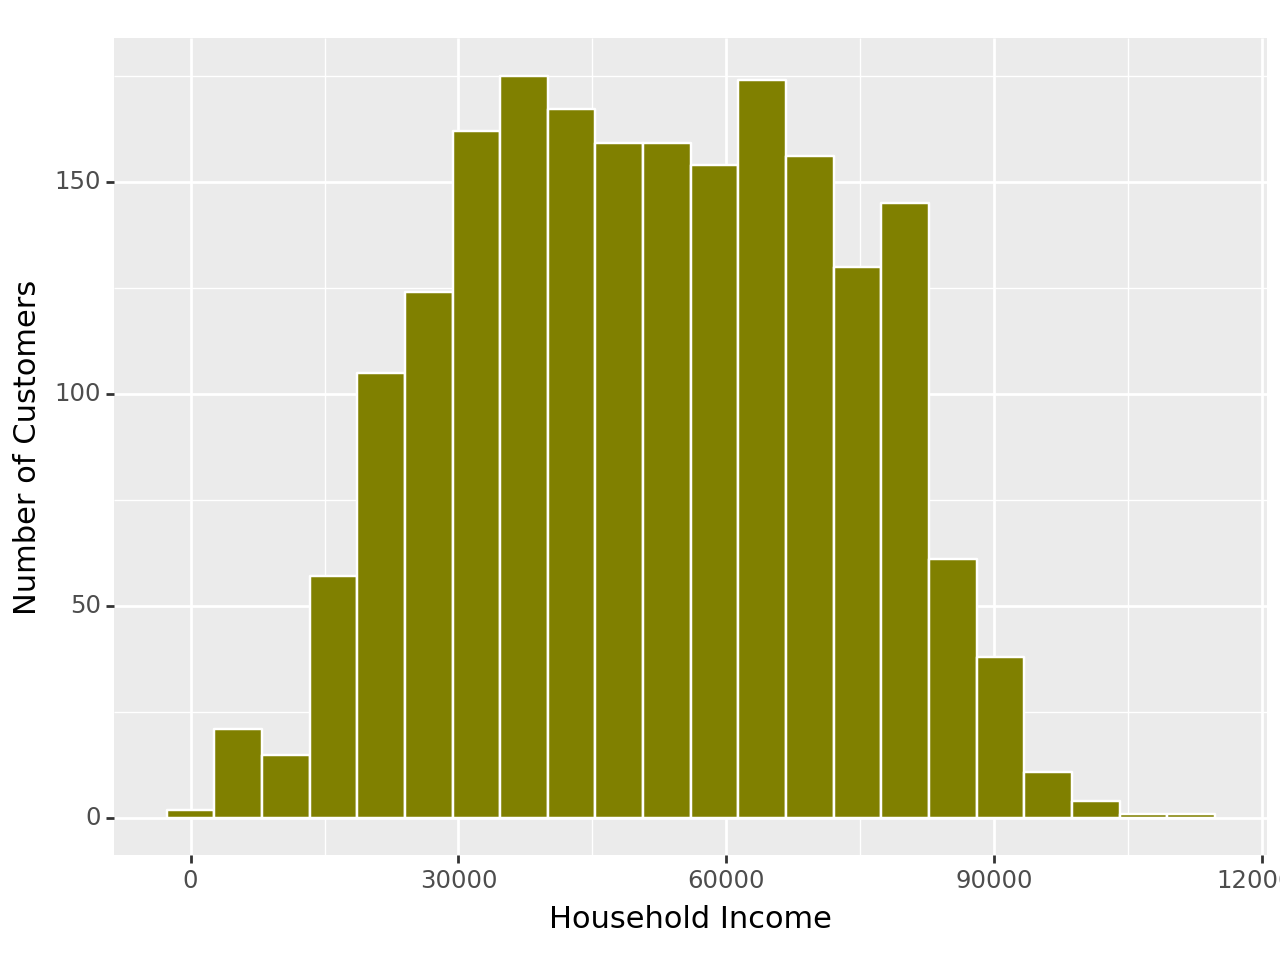

<Figure Size: (640 x 480)>

In [76]:
# @title Household Income Distribution
(
    ggplot(df_initial, aes(x='Income')) +
    geom_histogram(fill="olive", color='white') +
    xlab('Household Income') + ylab('Number of Customers')
)

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


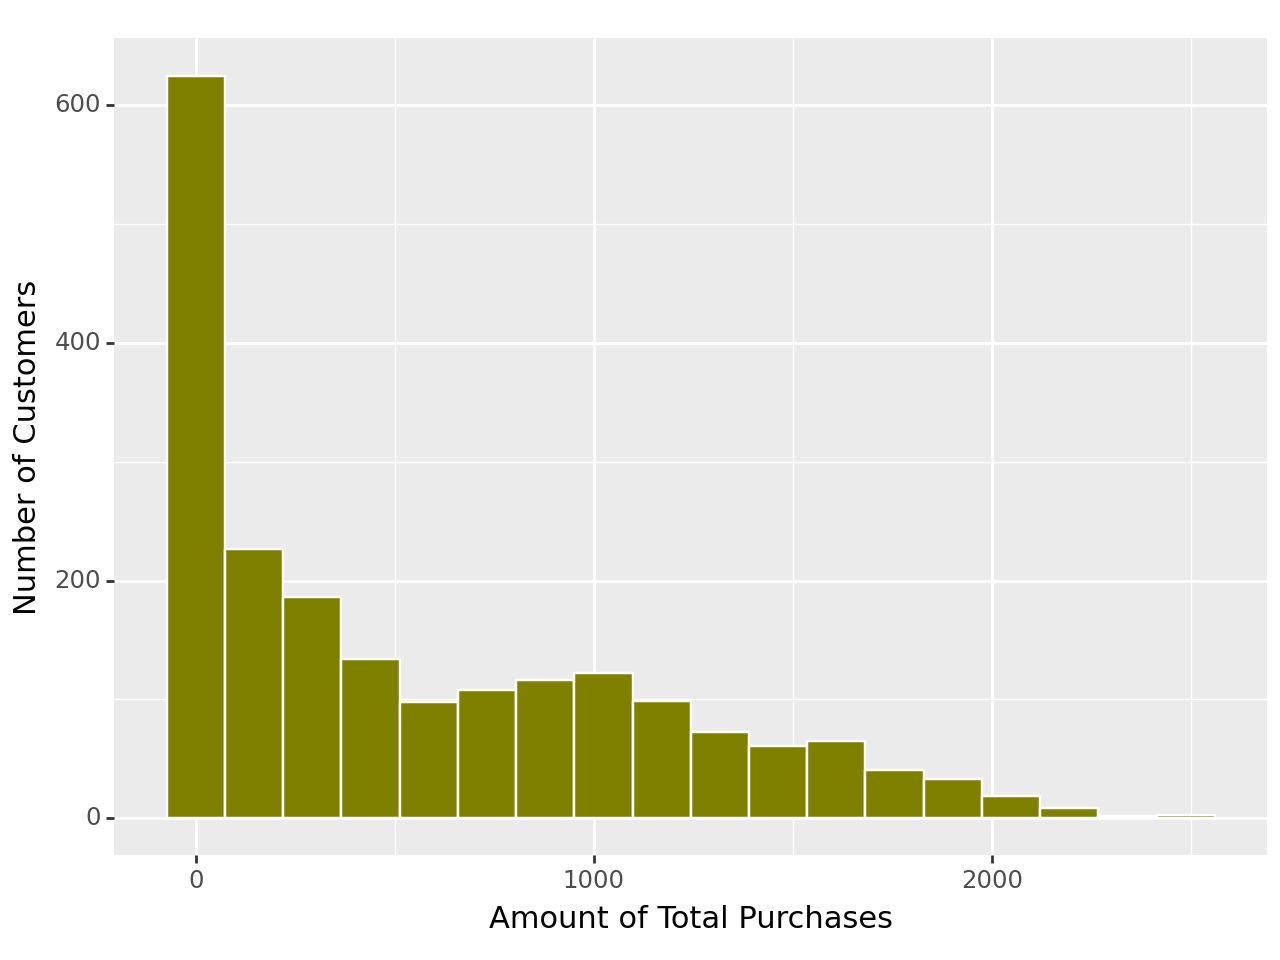

<Figure Size: (640 x 480)>

In [77]:
# @title Amount of Total Purchases by Customer
(
    ggplot(df_initial, aes(x='MntTotal')) +
    geom_histogram(fill="olive", color='white') +
    xlab('Amount of Total Purchases') + ylab('Number of Customers')
)

In [78]:
cmp_list = ['AcceptedCmp{}'.format(i) for i in range(1,6)]
cmp_list.append('Response')

cmp_df = pd.DataFrame(cmp_list, columns=['Campaign'])
cmp_df['Customers'] = 0
for i, row in cmp_df.iterrows():
  cmp_df.loc[i, 'Customers'] = df_initial.sum()[row['Campaign']].astype(int)

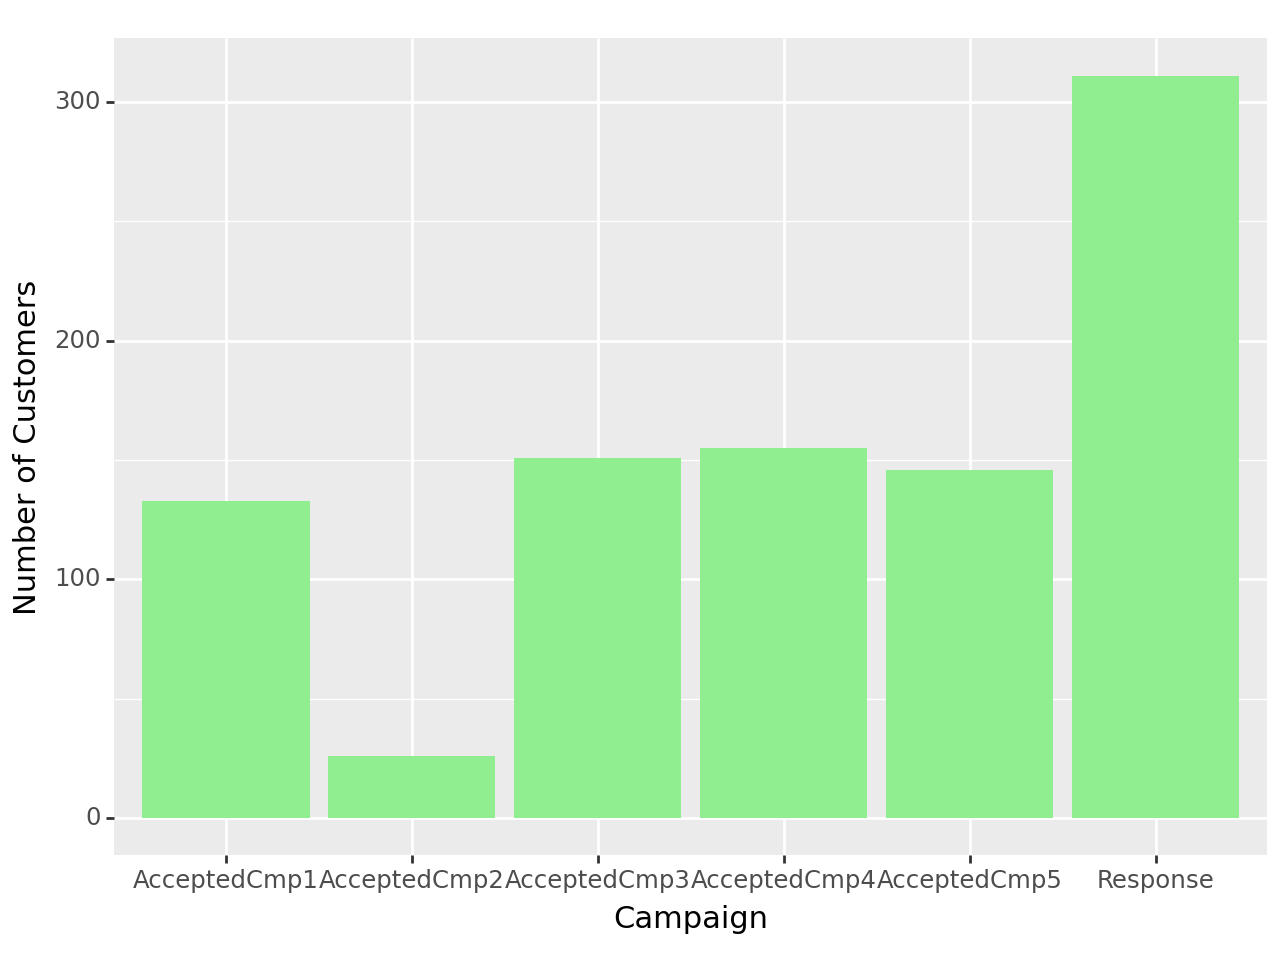

<Figure Size: (640 x 480)>

In [79]:
# @title Number of Customers of Each Campaign
(
    ggplot(cmp_df, aes(x='Campaign', weight='Customers')) +
    geom_bar(fill='lightgreen') +
    xlab('Campaign') + ylab('Number of Customers')
)

Here, I suspected that some campaigns may have less customers becauses they were introduced at a later data. However, judging from the first customers of each campaign, they were introduced at around the same time.

In [80]:
for cmp in cmp_list:
  mask = (df_initial[cmp] > 0)
  temp = df_initial[mask]
  cmp_date = temp['Customer_Days'].min()
  print(cmp_date)


2160
2171
2162
2159
2165
2165


## 2.2 Correlation

<Axes: >

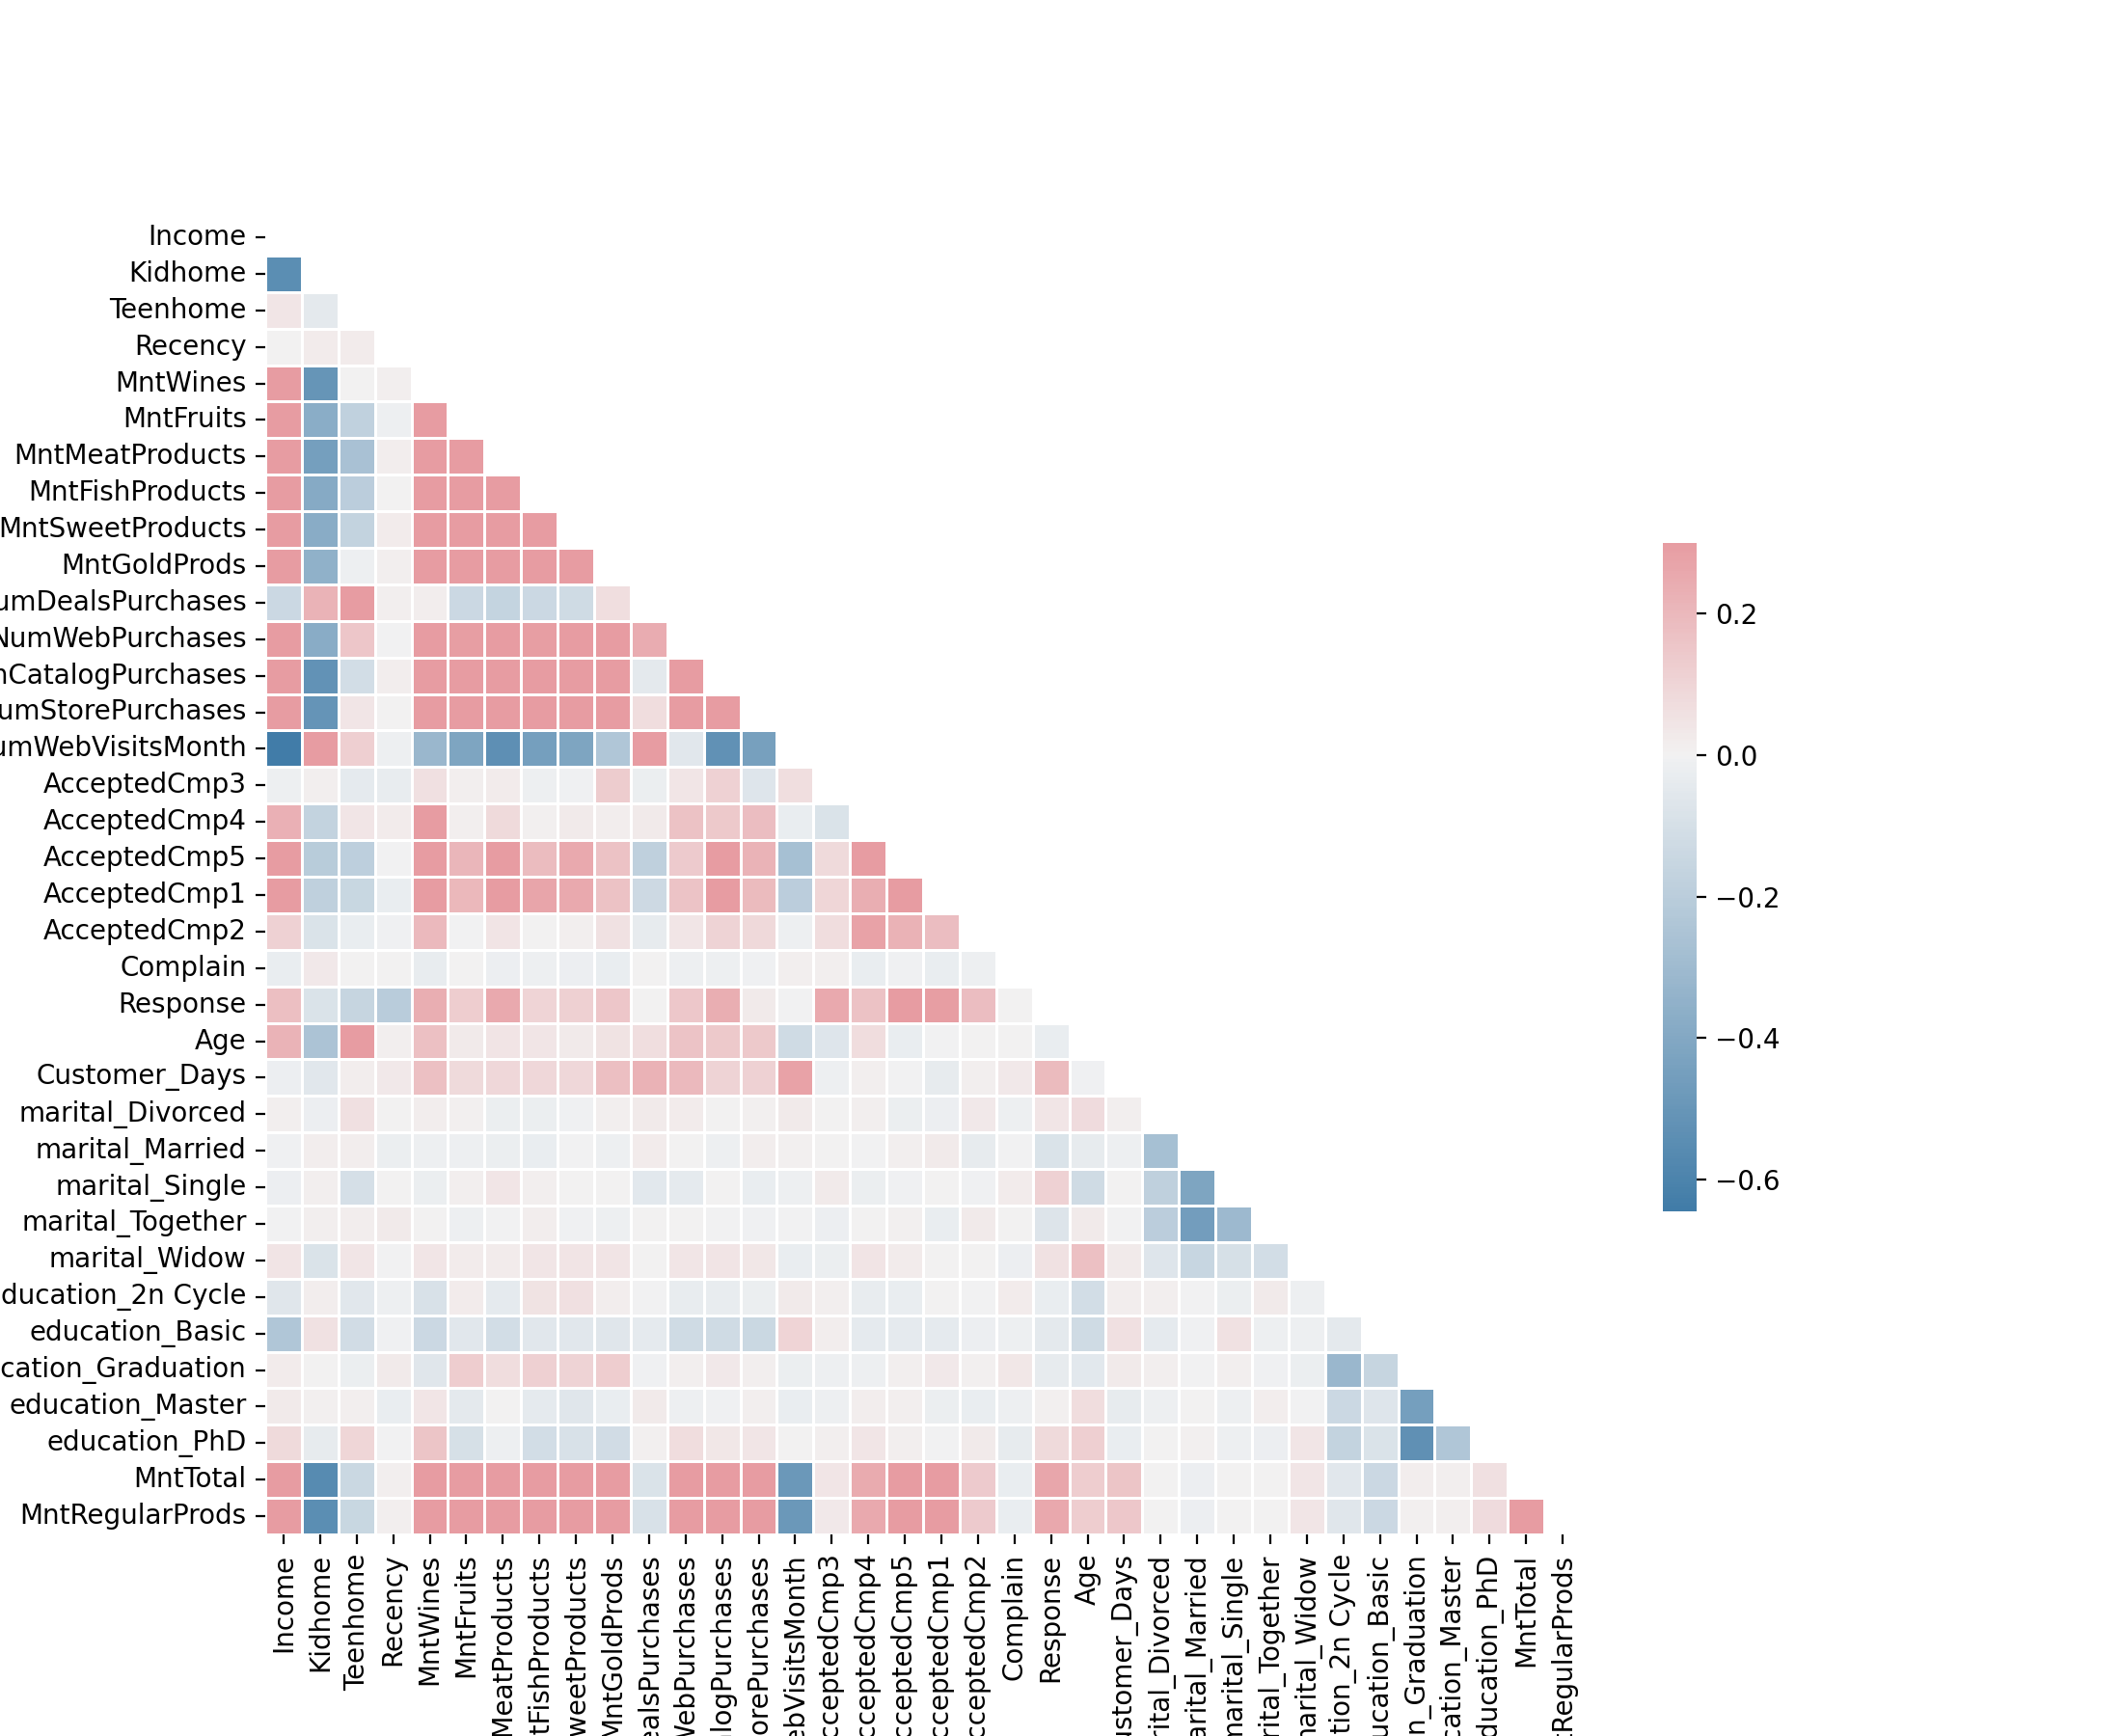

In [81]:
corr = df_initial.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As seen below, MntTotal and amount spent in other categories are highly correlated. This is expected as MntTotal is a summation of a categories.

In [82]:
s = corr.unstack()
so = s.abs().sort_values(kind="quicksort")
so = so[(so<1)]
so.tail(20)

MntWines             Income                 0.724708
Income               MntWines               0.724708
NumCatalogPurchases  MntRegularProds        0.775437
MntRegularProds      NumCatalogPurchases    0.775437
NumCatalogPurchases  MntTotal               0.787832
MntTotal             NumCatalogPurchases    0.787832
MntRegularProds      Income                 0.813709
Income               MntRegularProds        0.813709
                     MntTotal               0.819203
MntTotal             Income                 0.819203
MntMeatProducts      MntRegularProds        0.859577
MntRegularProds      MntMeatProducts        0.859577
MntMeatProducts      MntTotal               0.859909
MntTotal             MntMeatProducts        0.859909
MntWines             MntRegularProds        0.899770
MntRegularProds      MntWines               0.899770
MntTotal             MntWines               0.900320
MntWines             MntTotal               0.900320
MntRegularProds      MntTotal               0.

Removing the highly correlated variables. Income is highly correlated with spending.

In [83]:
to_drop = ['MntRegularProds', 'MntMeatProducts', 'MntWines',
           'MntFruits', 'MntFishProducts', 'MntSweetProducts']
temp = df_initial.drop(to_drop, axis=1)
corr = temp.corr()
s = corr.unstack()
so = s.abs().sort_values(kind="quicksort")
so = so[(so<1)]
so.tail(20)

education_Graduation  education_PhD           0.529131
education_PhD         education_Graduation    0.529131
Income                Kidhome                 0.540774
Kidhome               Income                  0.540774
                      MntTotal                0.556572
MntTotal              Kidhome                 0.556572
NumCatalogPurchases   NumStorePurchases       0.561754
NumStorePurchases     NumCatalogPurchases     0.561754
Income                NumWebVisitsMonth       0.643992
NumWebVisitsMonth     Income                  0.643992
MntTotal              NumStorePurchases       0.674334
NumStorePurchases     MntTotal                0.674334
Income                NumStorePurchases       0.684358
NumStorePurchases     Income                  0.684358
Income                NumCatalogPurchases     0.705481
NumCatalogPurchases   Income                  0.705481
                      MntTotal                0.787832
MntTotal              NumCatalogPurchases     0.787832
          

<Axes: >

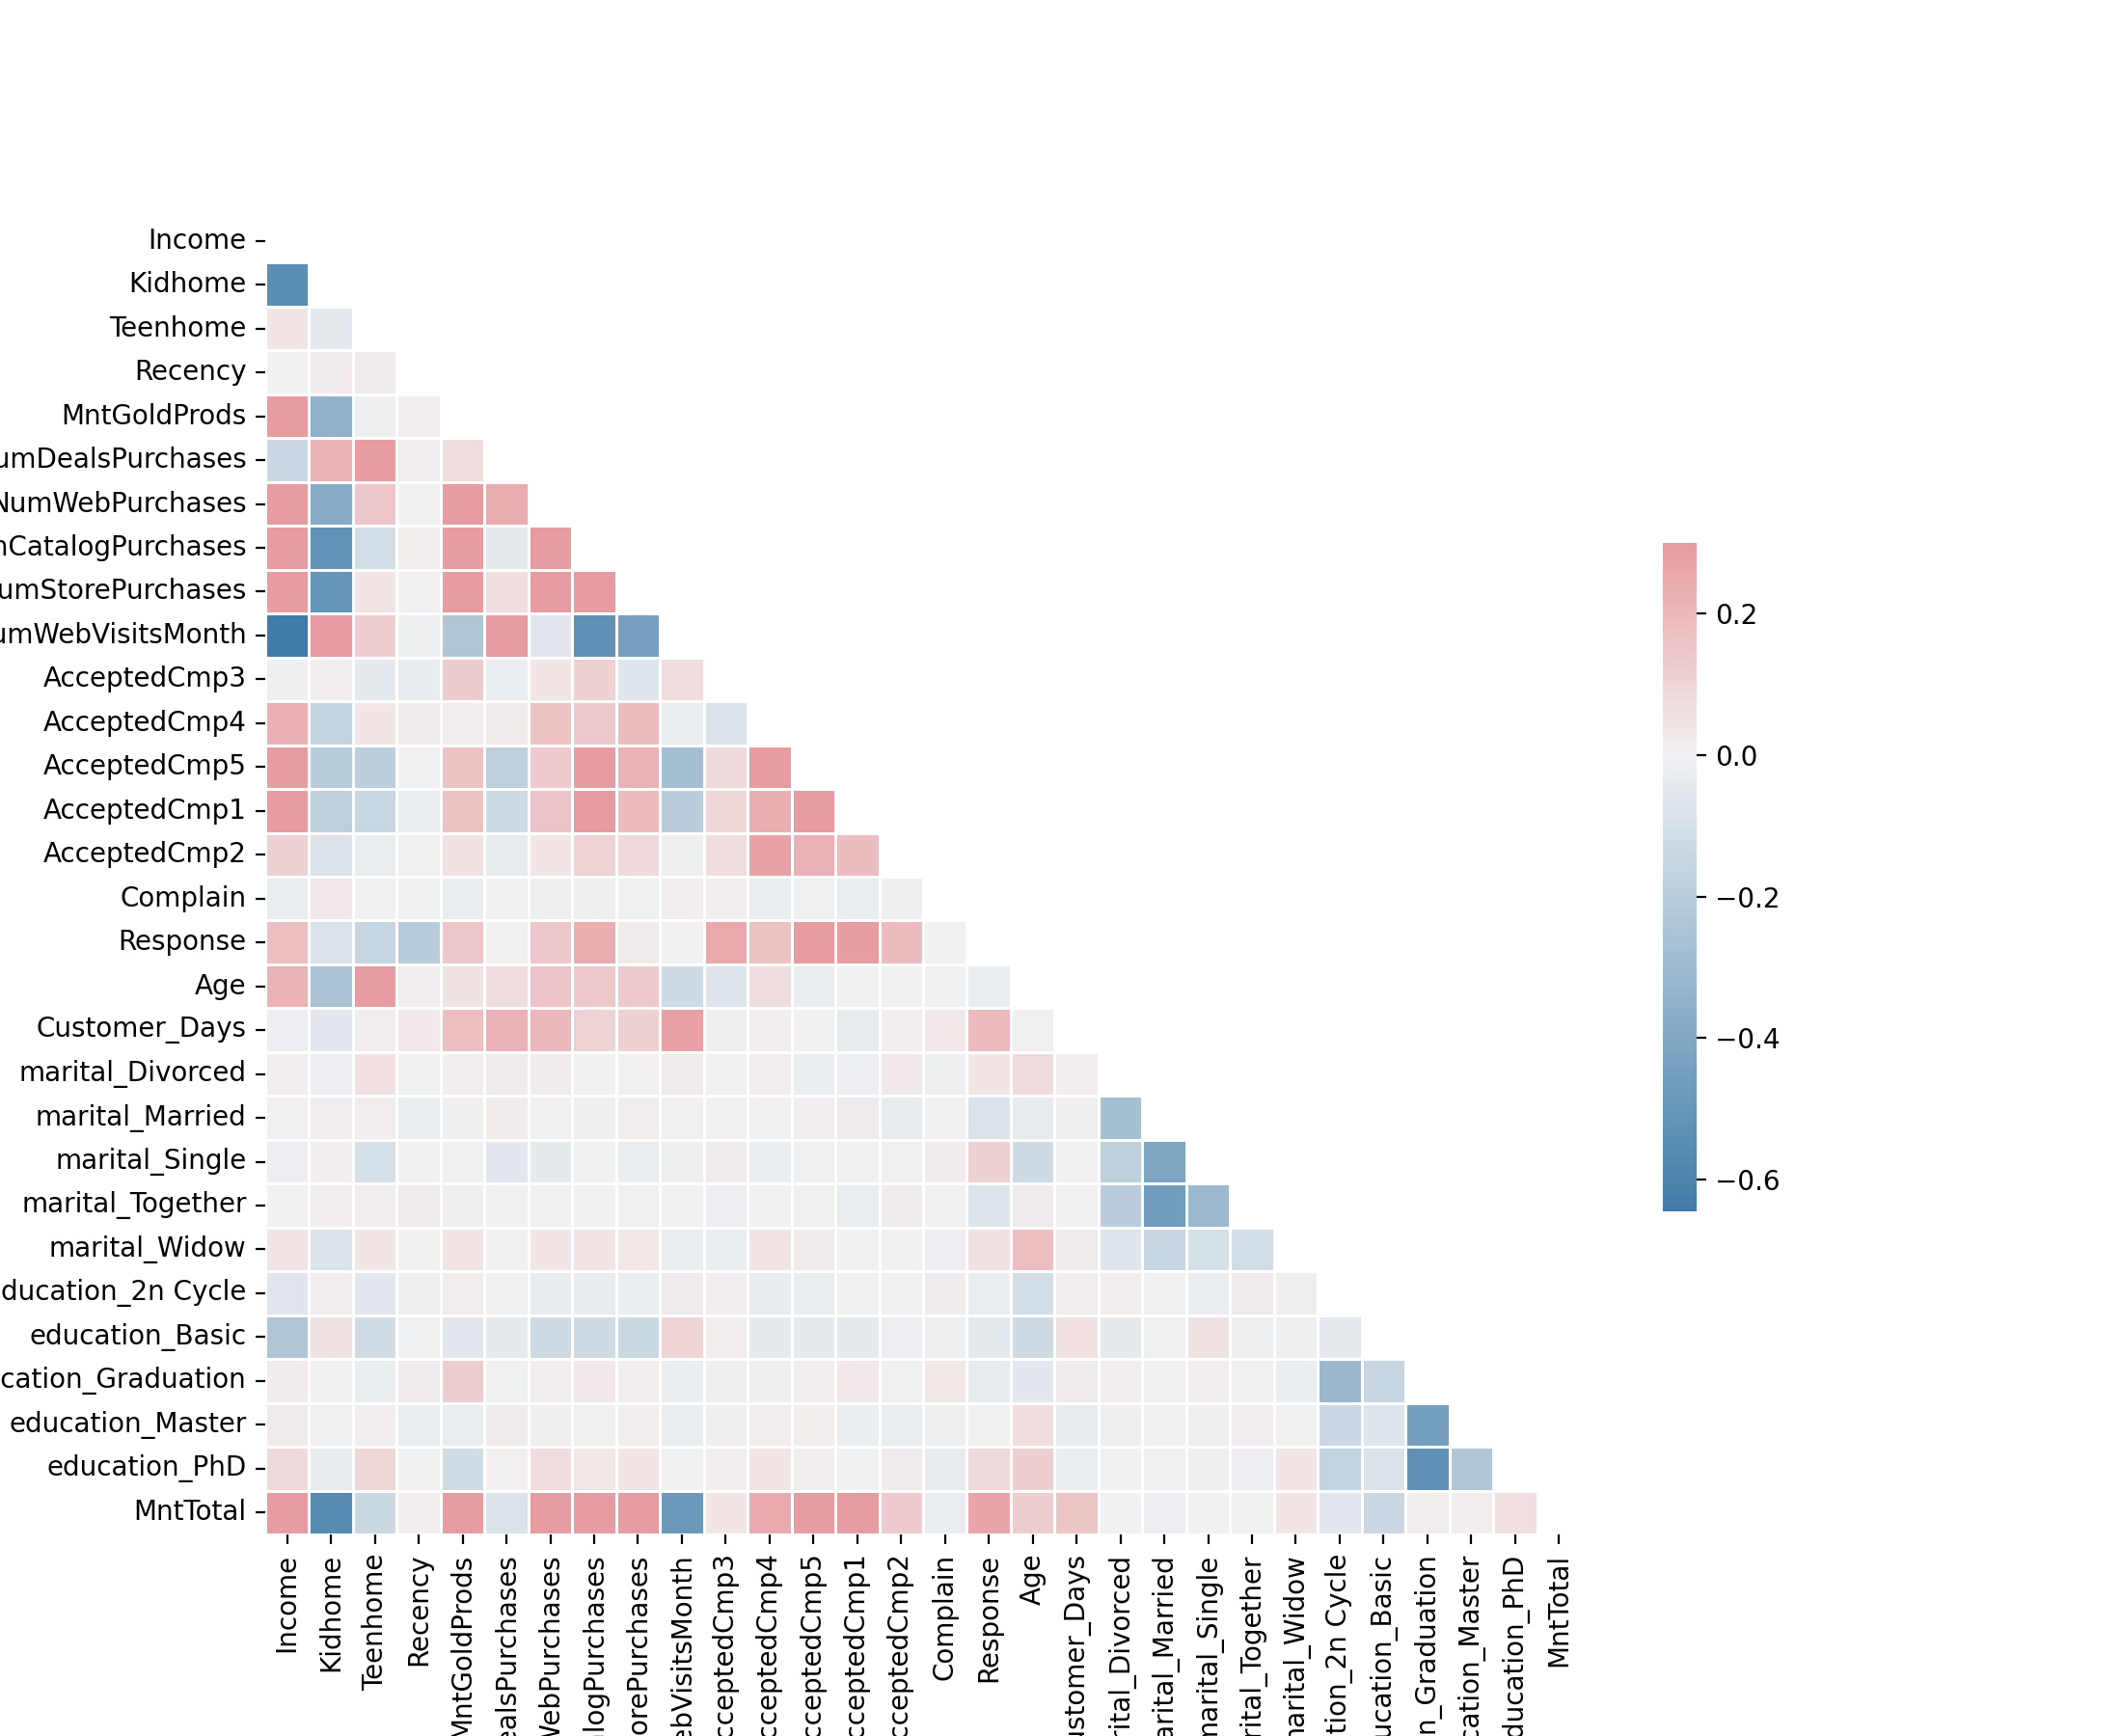

In [84]:
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2.3 Channels

In [85]:
chn_list = ['NumDealsPurchases', 'NumCatalogPurchases',
                 'NumStorePurchases', 'NumWebPurchases']

chn_df = pd.DataFrame(chn_list, columns=['Channel'])
chn_df['Purchases'] = 0
for i, row in chn_df.iterrows():
  chn_df.loc[i, 'Purchases'] = df_initial.sum()[row['Channel']].astype(int)

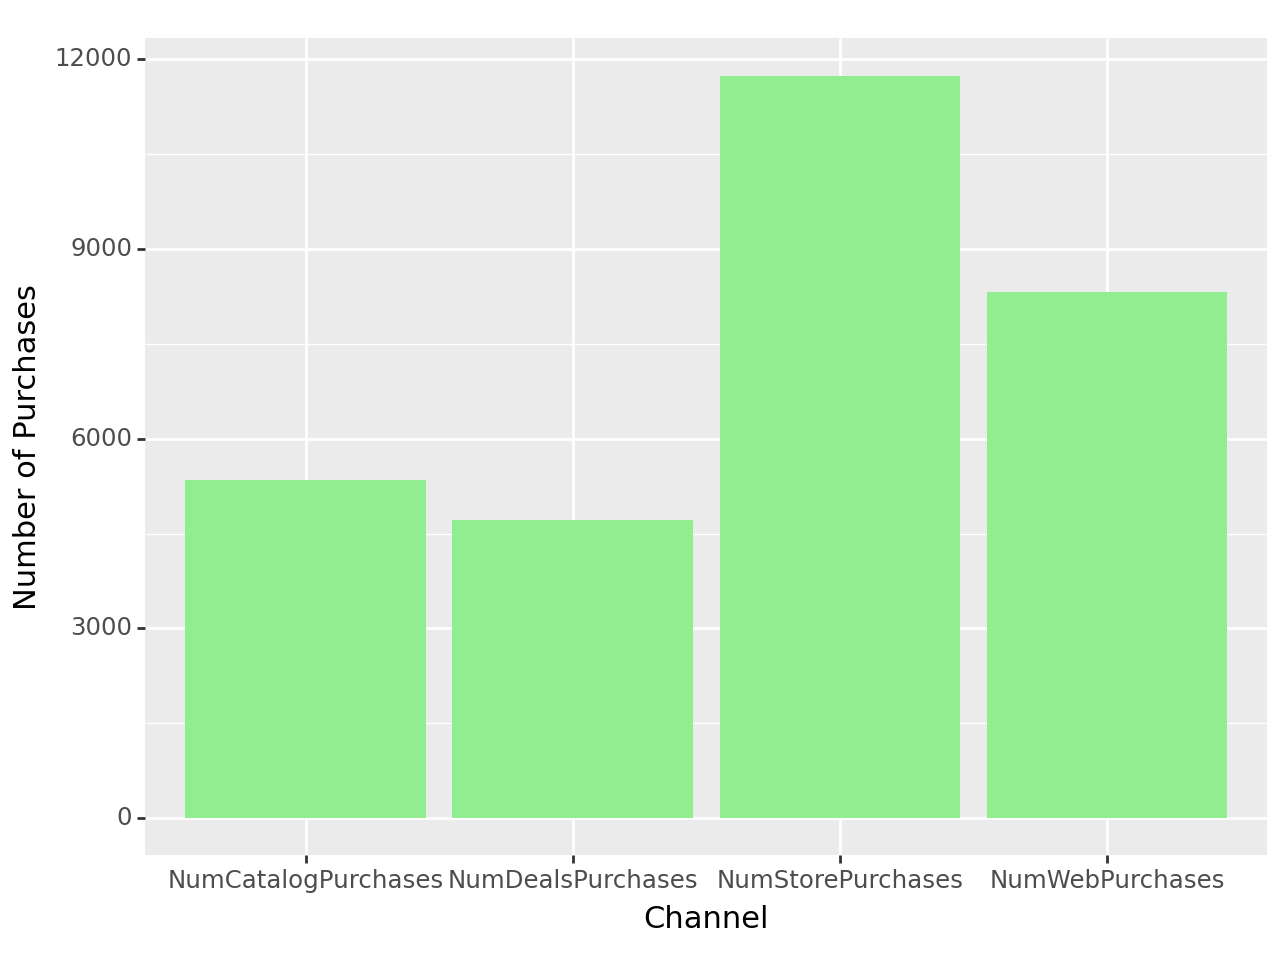

<Figure Size: (640 x 480)>

In [86]:
(
    ggplot(chn_df, aes(x='Channel', weight='Purchases')) +
    geom_bar(fill='lightgreen') +
    xlab('Channel') + ylab('Number of Purchases')
)

In [87]:
corr.loc[chn_list, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebVisitsMonth']]

AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  \
NumDealsPurchases       -0.133821     -0.036153     -0.021715      0.024413   
NumCatalogPurchases      0.329637      0.107065      0.108703      0.143566   
NumStorePurchases        0.189449      0.087016     -0.069885      0.178959   
NumWebPurchases          0.159962      0.039878      0.042104      0.168272   

                     AcceptedCmp5  Response  NumWebVisitsMonth  
NumDealsPurchases       -0.186031 -0.000464           0.363911  
NumCatalogPurchases      0.337303  0.233975          -0.522821  
NumStorePurchases        0.215473  0.030087          -0.444680  
NumWebPurchases          0.138971  0.145522          -0.056338

# 3. Feature Engineering
---

In [88]:
df = df_initial.copy(deep=True)
df['Dependants'] = df['Teenhome'] + df['Kidhome']
df['MntIndex'] = df['MntTotal'] / (df['Customer_Days'] * df['Income']/10000 * df['Dependants'])
df['MntIndex'] = df['MntTotal'] / df['Customer_Days']

In [89]:
df.head()

Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  MntMeatProducts  \
0  58138.0        0         0       58       635         88              546   
1  46344.0        1         1       38        11          1                6   
2  71613.0        0         0       26       426         49              127   
3  26646.0        1         0       26        11          4               20   
4  58293.0        1         0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27            15                  5   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                8                   10                  4                  7   
1                1                    1                  2                  5   
2                8                    2                 10                  4   
3                2                    0                  4                  6   
4                5                    3                  6                  5   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Complain  Response  Age  Customer_Days  marital_Divorced  marital_Married  \
0         0         1   63           2822                 0                0   
1         0         0   66           2272                 0                0   
2         0         0   55           2471                 0                0   
3         0         0   36           2298                 0                0   
4         0         0   39           2320                 0                1   

   marital_Single  marital_Together  marital_Widow  education_2n Cycle  \
0               1                 0              0                   0   
1               1                 0              0                   0   
2               0                 1              0                   0   
3               0                 1              0                   0   
4               0                 0              0                   0   

   education_Basic  education_Graduation  education_Master  education_PhD  \
0                0                     1                 0              0   
1                0                     1                 0              0   
2                0                     1                 0              0   
3                0                     1                 0              0   
4                0                     0                 0              1   

   MntTotal  MntRegularProds  Dependants  MntIndex  
0      1529             1441           0  0.541814  
1        21               15           2  0.009243  
2       734              692           0  0.297046  
3        48               43           1  0.020888  
4       407              392           1  0.175431

# 4. Customer Segmentation
---

## 4.1 Kmeans

In [90]:
customers_df = df[['Income', 'MntTotal', 'Dependants', 'Recency', 'Customer_Days', 'Age']]
customers_df.head()

Income  MntTotal  Dependants  Recency  Customer_Days  Age
0  58138.0      1529           0       58           2822   63
1  46344.0        21           2       38           2272   66
2  71613.0       734           0       26           2471   55
3  26646.0        48           1       26           2298   36
4  58293.0       407           1       94           2320   39

In [91]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(customers_df))
X.describe()

0             1             2             3             4  \
count  2.021000e+03  2.021000e+03  2.021000e+03  2.021000e+03  2.021000e+03   
mean  -1.494214e-17 -8.877389e-17 -8.262125e-17  5.625276e-17  1.049466e-15   
std    1.000247e+00  1.000247e+00  1.000247e+00  1.000247e+00  1.000247e+00   
min   -2.412471e+00 -9.707894e-01 -1.277576e+00 -1.688819e+00 -1.741328e+00   
25%   -7.857505e-01 -8.823449e-01 -1.277576e+00 -8.596242e-01 -8.623010e-01   
50%   -1.329244e-02 -3.828938e-01  6.301647e-02  4.119987e-03 -3.027521e-03   
75%    8.009853e-01  6.940476e-01  6.301647e-02  8.678642e-01  8.710610e-01   
max    2.996281e+00  3.342179e+00  2.744201e+00  1.731608e+00  1.710581e+00   

                  5  
count  2.021000e+03  
mean   3.867378e-17  
std    1.000247e+00  
min   -2.324723e+00  
25%   -6.958814e-01  
50%   -9.578179e-02  
75%    8.472319e-01  
max    2.476074e+00

In [92]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Text(0.5, 1.0, 'The Elbow Method using Inertia')

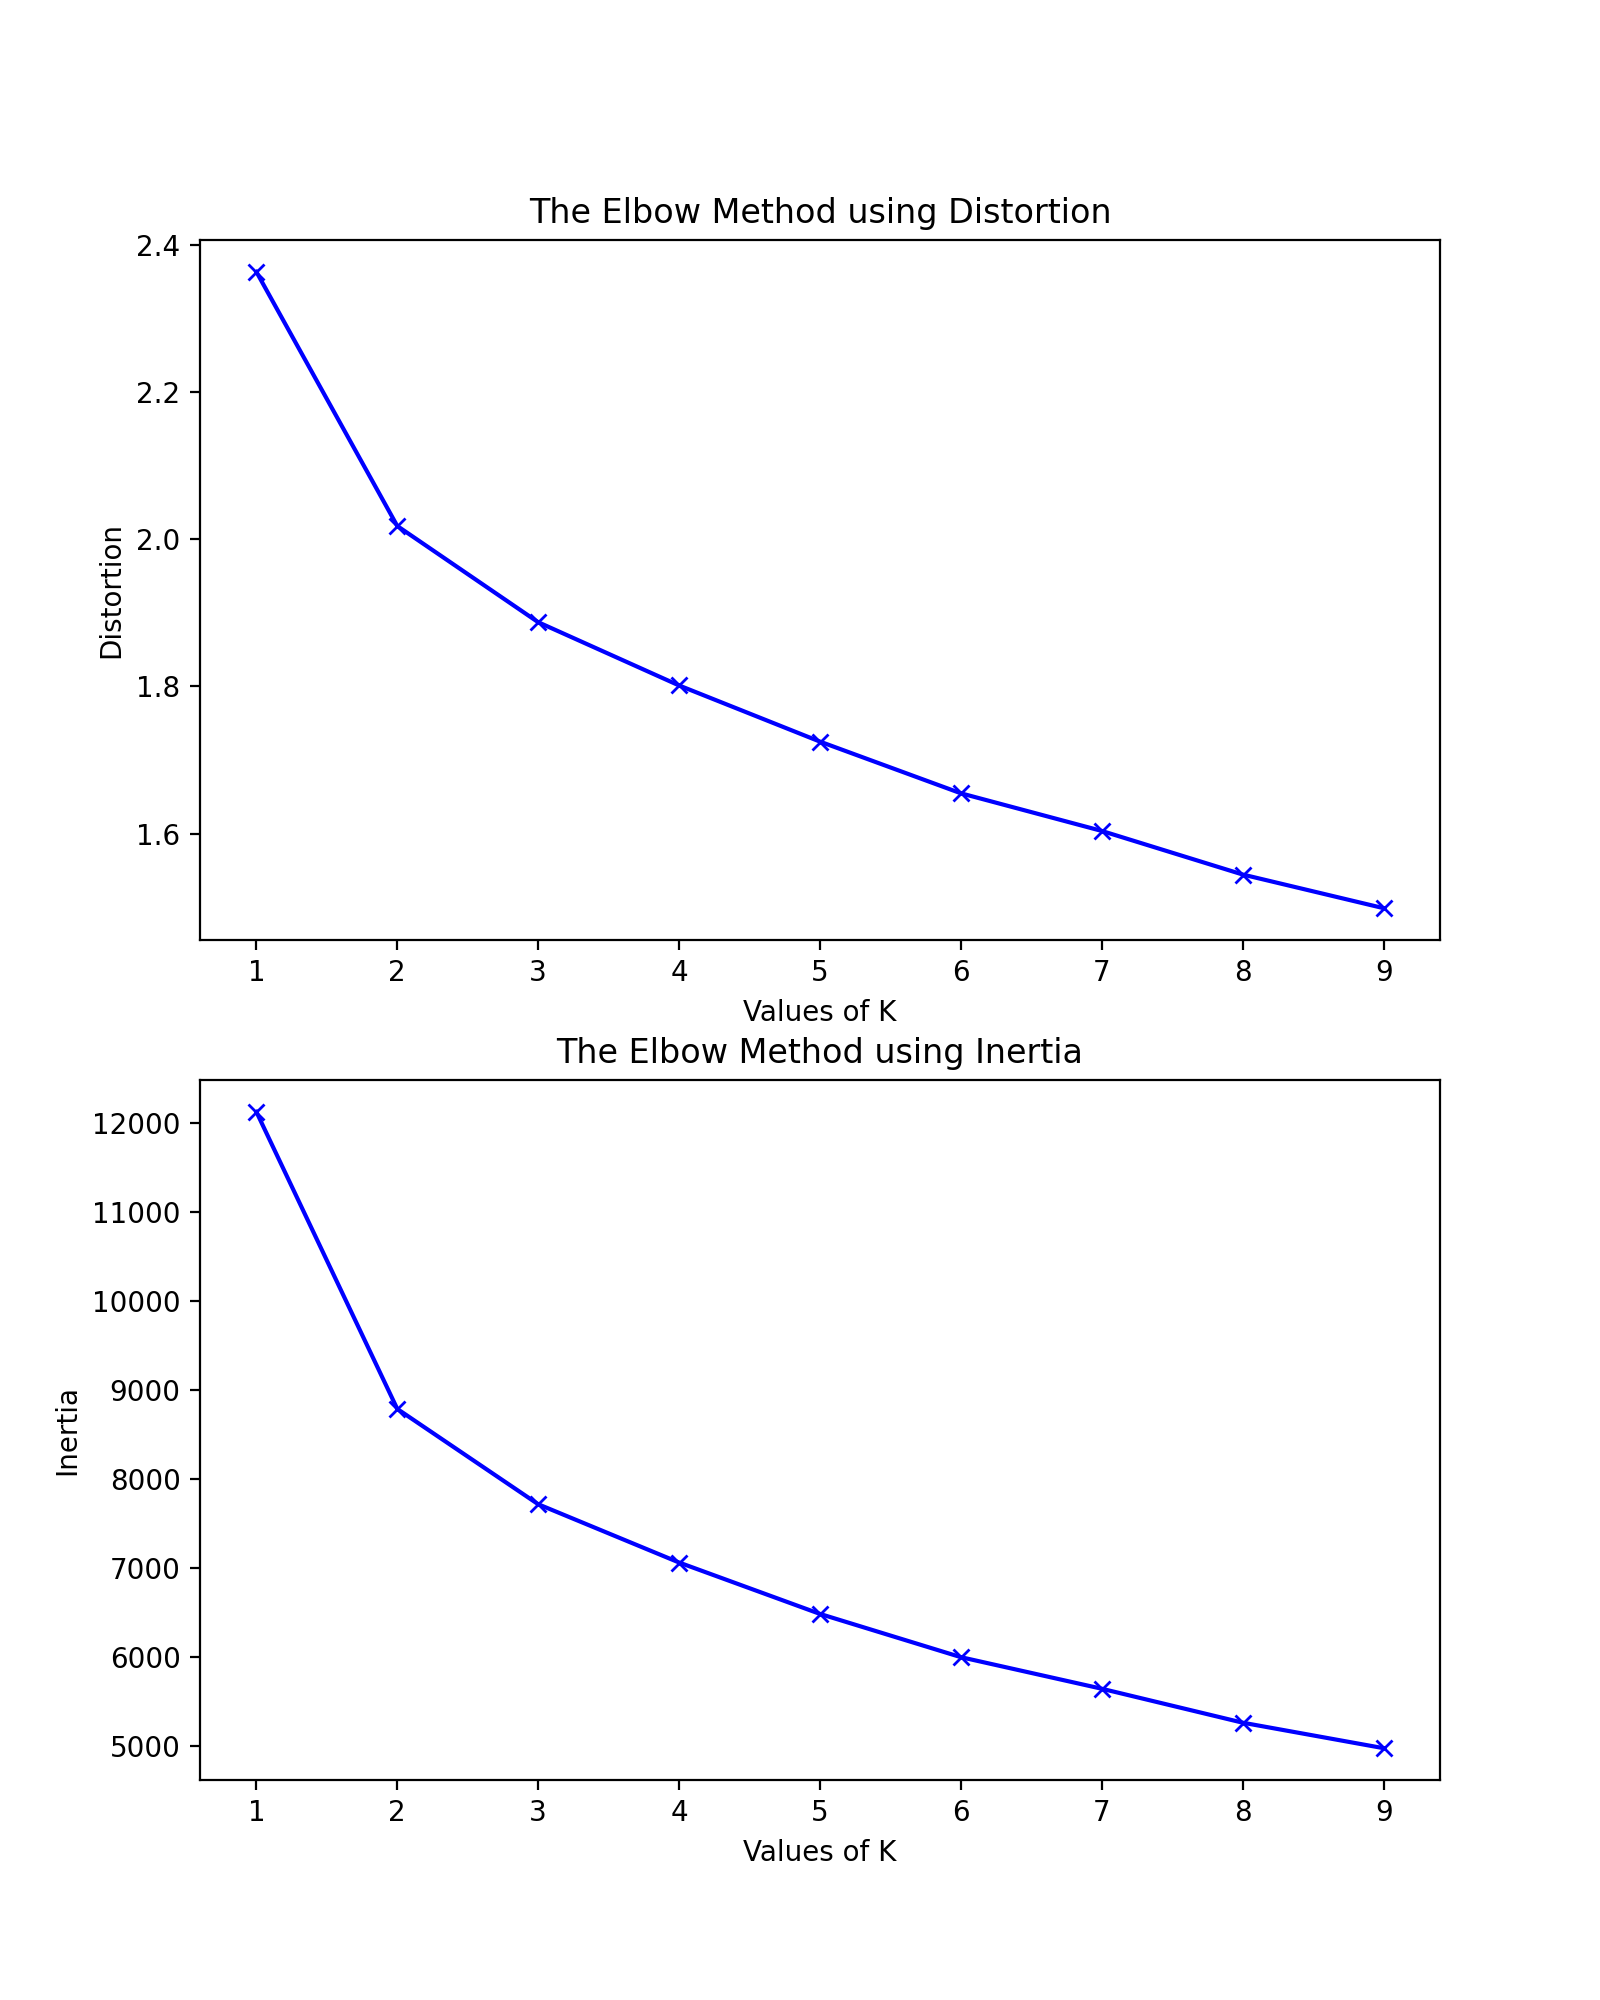

In [93]:
fig, ax = plt.subplots(2,1, figsize=(8, 10))
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[0].set_title('The Elbow Method using Distortion')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia')
ax[1].set_title('The Elbow Method using Inertia')

In [94]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=2024)
kmeans.fit(X)
clusters = kmeans.predict(X)
Counter(clusters)

Counter({0: 687, 1: 675, 2: 659})

In [95]:
shs(X,clusters)

0.18293777434503314

In [96]:
customers_df.loc[:, 'Pred'] = clusters

<ipython-input-96-a38d2860cd91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [97]:
customers_df.groupby('Pred').mean()

Income     MntTotal  Dependants    Recency  Customer_Days  \
Pred                                                                    
0     73659.187773  1242.668122    0.385735  48.213974    2534.768559   
1     38403.355556   185.893333    1.161481  24.521481    2485.943704   
2     42388.198786   243.136571    1.330804  74.526555    2513.766313   

            Age  
Pred             
0     53.183406  
1     48.404444  
2     51.742033

In [98]:
df['Pred'] = customers_df['Pred']
df.groupby('Pred').mean()

Income   Kidhome  Teenhome    Recency    MntWines  MntFruits  \
Pred                                                                       
0     73659.187773  0.043668  0.342067  48.213974  653.222707  58.061135   
1     38403.355556  0.651852  0.509630  24.521481  106.970370   9.120000   
2     42388.198786  0.646434  0.684370  74.526555  149.396055  10.984825   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
Pred                                                                     
0          388.487627        83.024745         59.871907     74.058224   
1           47.242963        13.386667          9.173333     25.800000   
2           55.883156        15.057663         11.814871     31.066768   

      NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
Pred                                                            
0              1.704512         5.668122             5.462882   
1              2.496296         3.100741             1.068148   
2              2.811836         3.535660             1.321700   

      NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
Pred                                                                     
0              8.528384           3.553130      0.080058      0.151383   
1              4.155556           6.320000      0.088889      0.029630   
2              4.663126           6.200303      0.054628      0.047041   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response        Age  \
Pred                                                                            
0         0.212518      0.177584      0.032023  0.005822  0.254731  53.183406   
1         0.000000      0.010370      0.004444  0.014815  0.151111  48.404444   
2         0.000000      0.006070      0.001517  0.007587  0.051593  51.742033   

      Customer_Days  marital_Divorced  marital_Married  marital_Single  \
Pred                                                                     
0       2534.768559          0.112082          0.37409        0.222707   
1       2485.943704          0.096296          0.41037        0.226667   
2       2513.766313          0.109256          0.38088        0.207891   

      marital_Together  marital_Widow  education_2n Cycle  education_Basic  \
Pred                                                                         
0             0.244541       0.046579            0.080058         0.000000   
1             0.238519       0.028148            0.099259         0.044444   
2             0.273141       0.028832            0.092564         0.028832   

      education_Graduation  education_Master  education_PhD     MntTotal  \
Pred                                                                       
0                 0.521106          0.160116       0.238719  1242.668122   
1                 0.500741          0.165926       0.189630   185.893333   
2                 0.484067          0.171472       0.223065   243.136571   

      MntRegularProds  Dependants  MntIndex  
Pred                                         
0         1168.609898    0.385735  0.491606  
1          160.093333    1.161481  0.074047  
2          212.069803    1.330804  0.095659

## 4.2 HDBSCAN


In [99]:
!pip install hdbscan
from hdbscan import HDBSCAN

Search for hyperparameters that maximizes Density Based Clustering Validation index (DBCV)

In [100]:
min_cluster_space = np.arange(19, 20, 1)
min_samples_space = np.arange(4, 13, 1)
min_cluster_opt = 0.5
samples_opt = 5
DBCV_high = 0

for c in min_cluster_space:
  for samples in min_samples_space:
      clusterer = HDBSCAN(min_samples=samples,
                    min_cluster_size=c,
                    algorithm='best',
                    gen_min_span_tree=True)

      clusterer.fit(X)
      DBCV = clusterer.relative_validity_
      if DBCV > DBCV_high:
        DBCV_high = DBCV
        min_cluster_opt = c
        samples_opt = samples

print(samples_opt)
print(min_cluster_opt)

8
19


In [101]:
clusterer = HDBSCAN(min_samples=samples_opt,
                    min_cluster_size=30,
                    algorithm='best',
                    cluster_selection_epsilon=0.5,
                    gen_min_span_tree=True)

clusterer.fit(X)
clusterer.relative_validity_

0.013224861281737825

In [102]:
clusters_hdbscan = clusterer.labels_
Counter(clusters_hdbscan)

Counter({-1: 256, 1: 354, 2: 351, 0: 1011, 3: 49})

In [103]:
df['HDBSCANPred'] = clusters_hdbscan
df['HDBSCANPred'] = df['HDBSCANPred'].apply(str)

## 4.3 Visualizing the Clusters

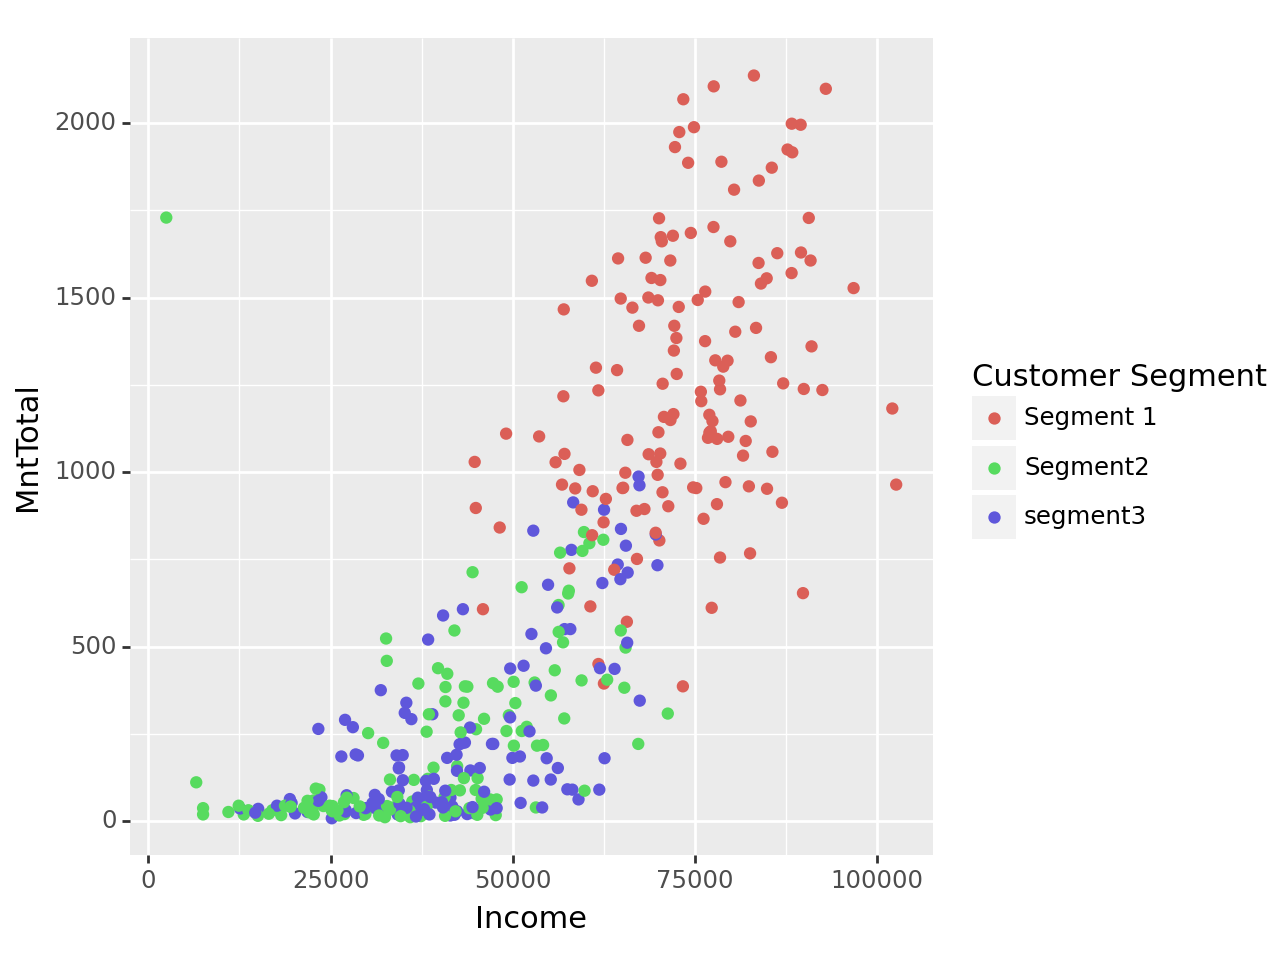

<Figure Size: (640 x 480)>

In [104]:
# @title K Means Clusters on a MntTotal against Income Scatter Plot
df['Pred'] = df['Pred'].apply(str)
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'Income', y = 'MntTotal', color='Pred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment", labels=["Segment 1", "Segment2", "segment3"])
    )

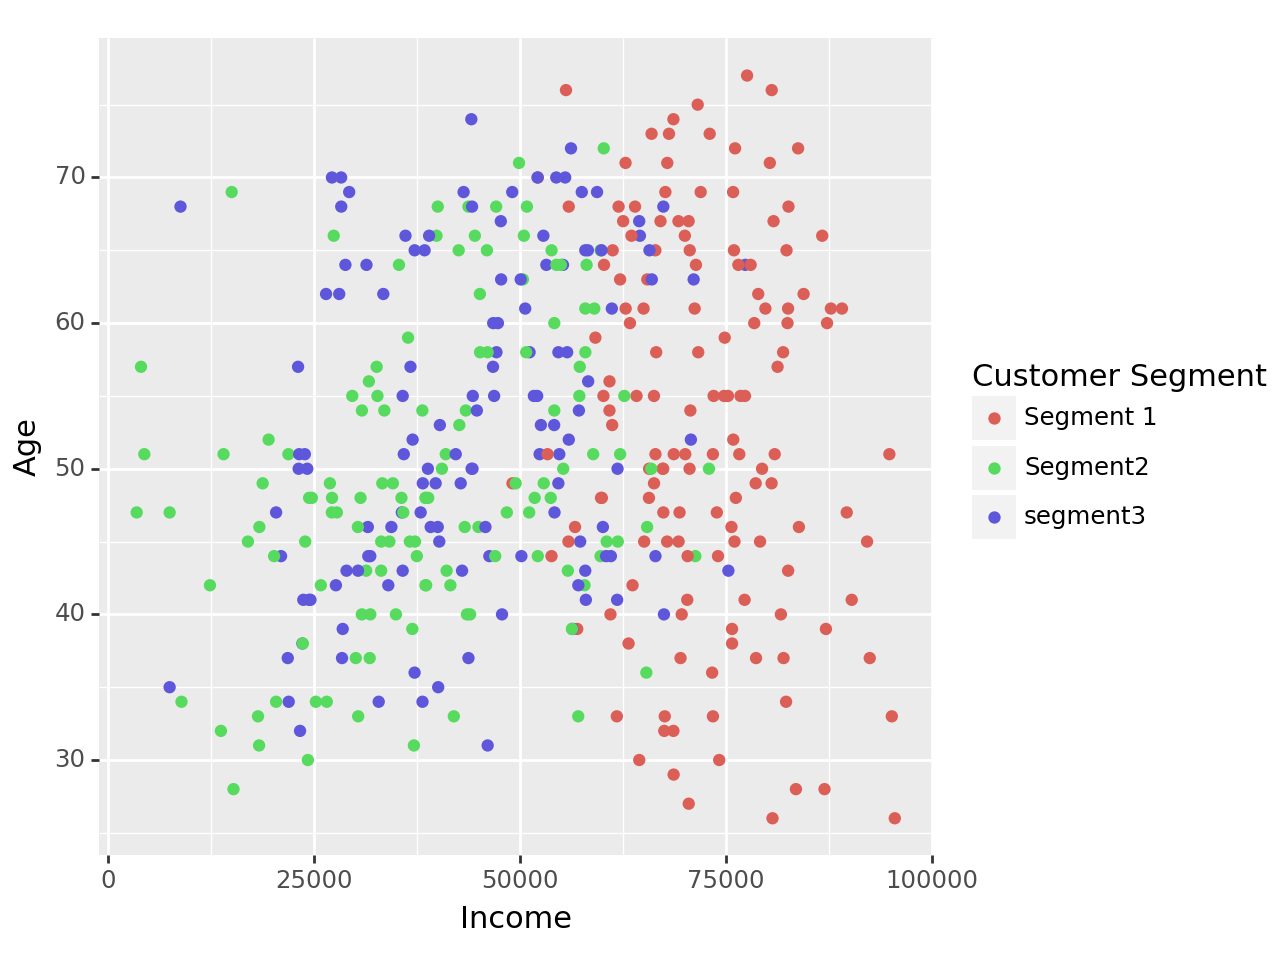

<Figure Size: (640 x 480)>

In [105]:
# @title K Means Clusters on a Age against Income Scatter Plot
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'Income', y = 'Age', color='Pred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment", labels=["Segment 1", "Segment2", "segment3"])
    )

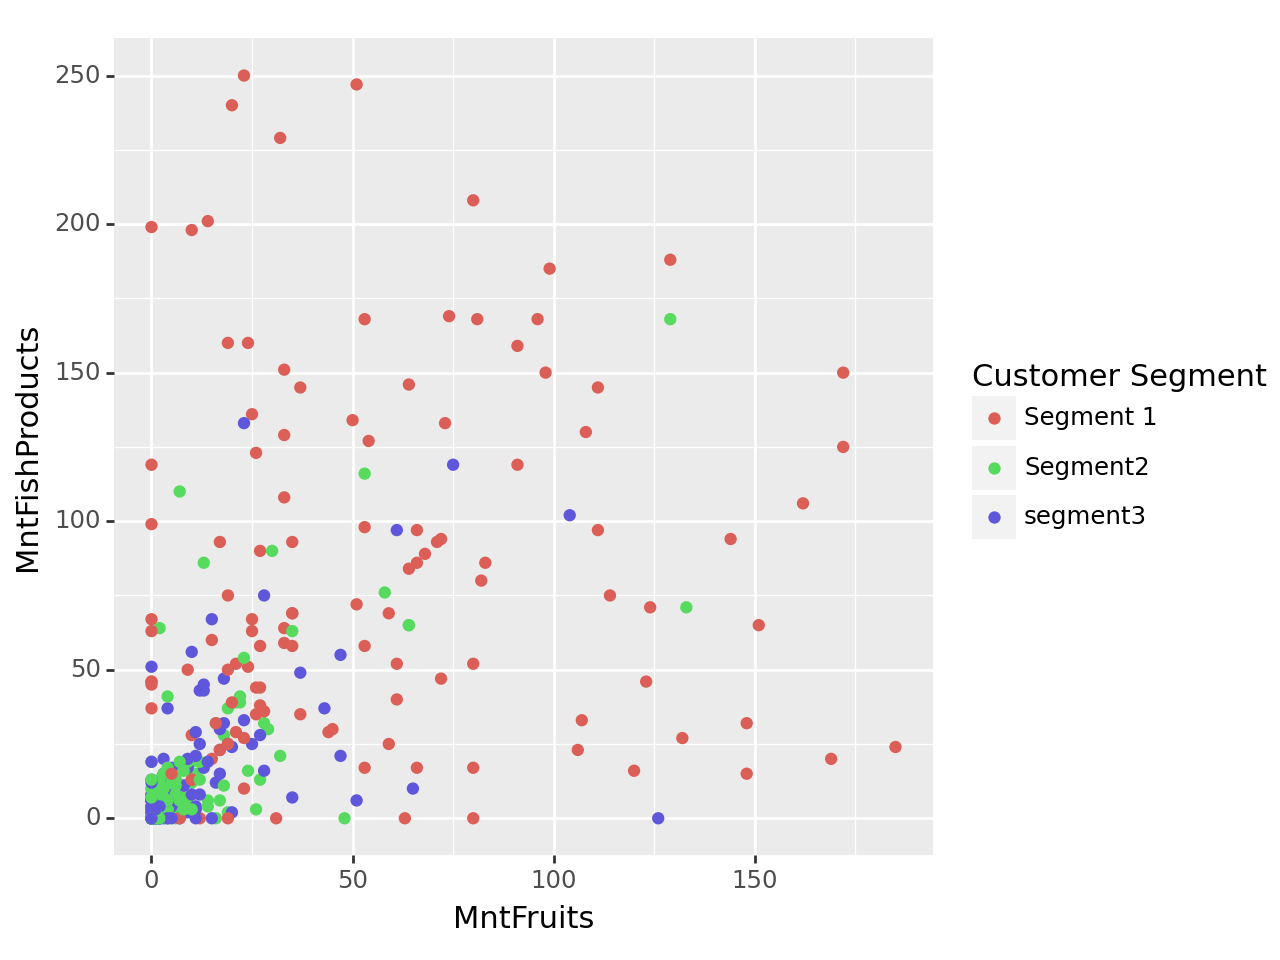

<Figure Size: (640 x 480)>

In [106]:
# @title Customer Segments
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'MntFruits', y = 'MntFishProducts', color='Pred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment", labels=["Segment 1", "Segment2", "segment3"])
    )

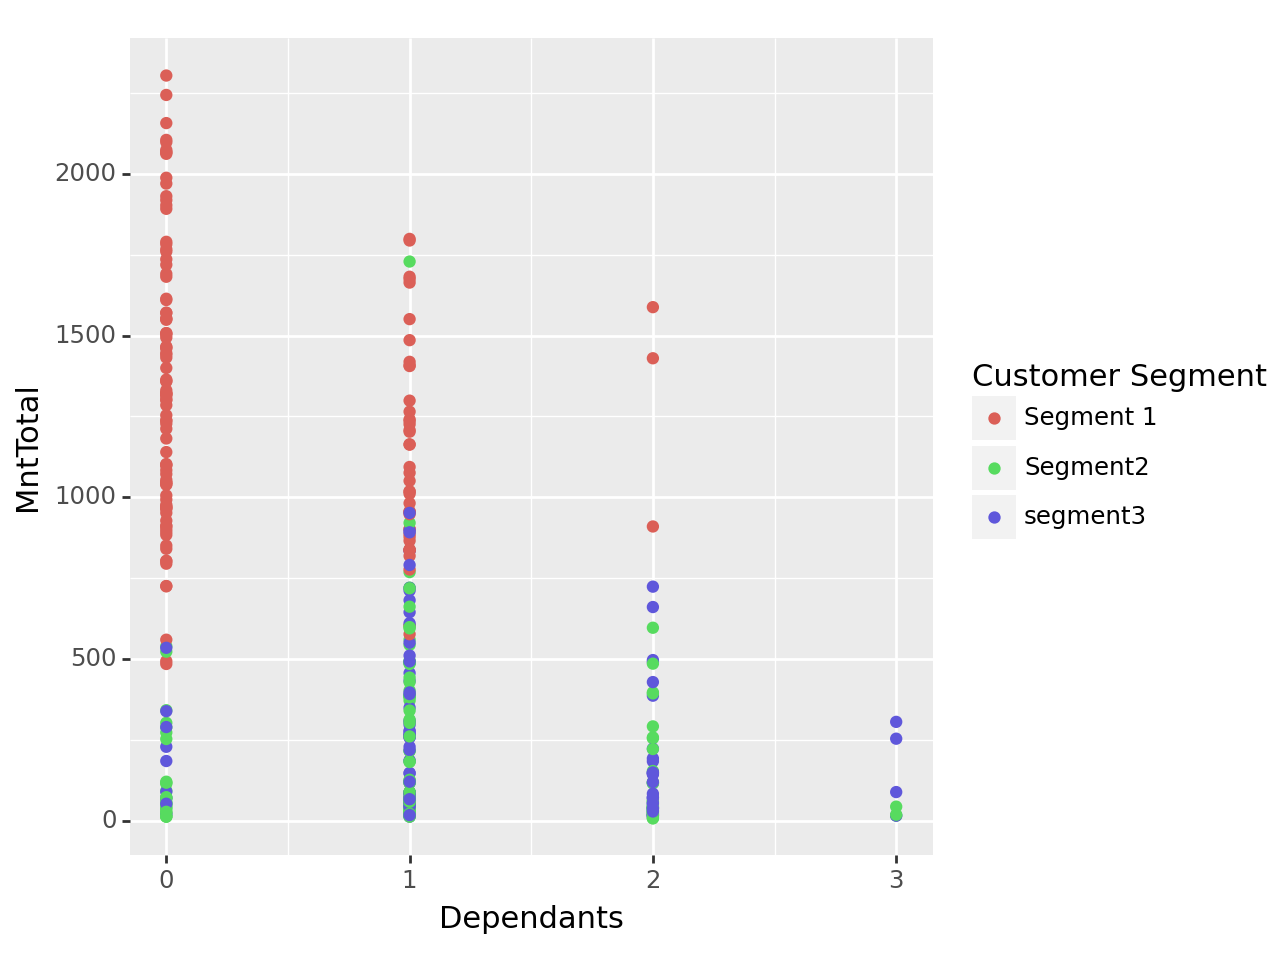

<Figure Size: (640 x 480)>

In [107]:
# @title K Means Clusters on a Age against Income Scatter Plot
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'Dependants', y = 'MntTotal', color='Pred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment", labels=["Segment 1", "Segment2", "segment3"])
    )

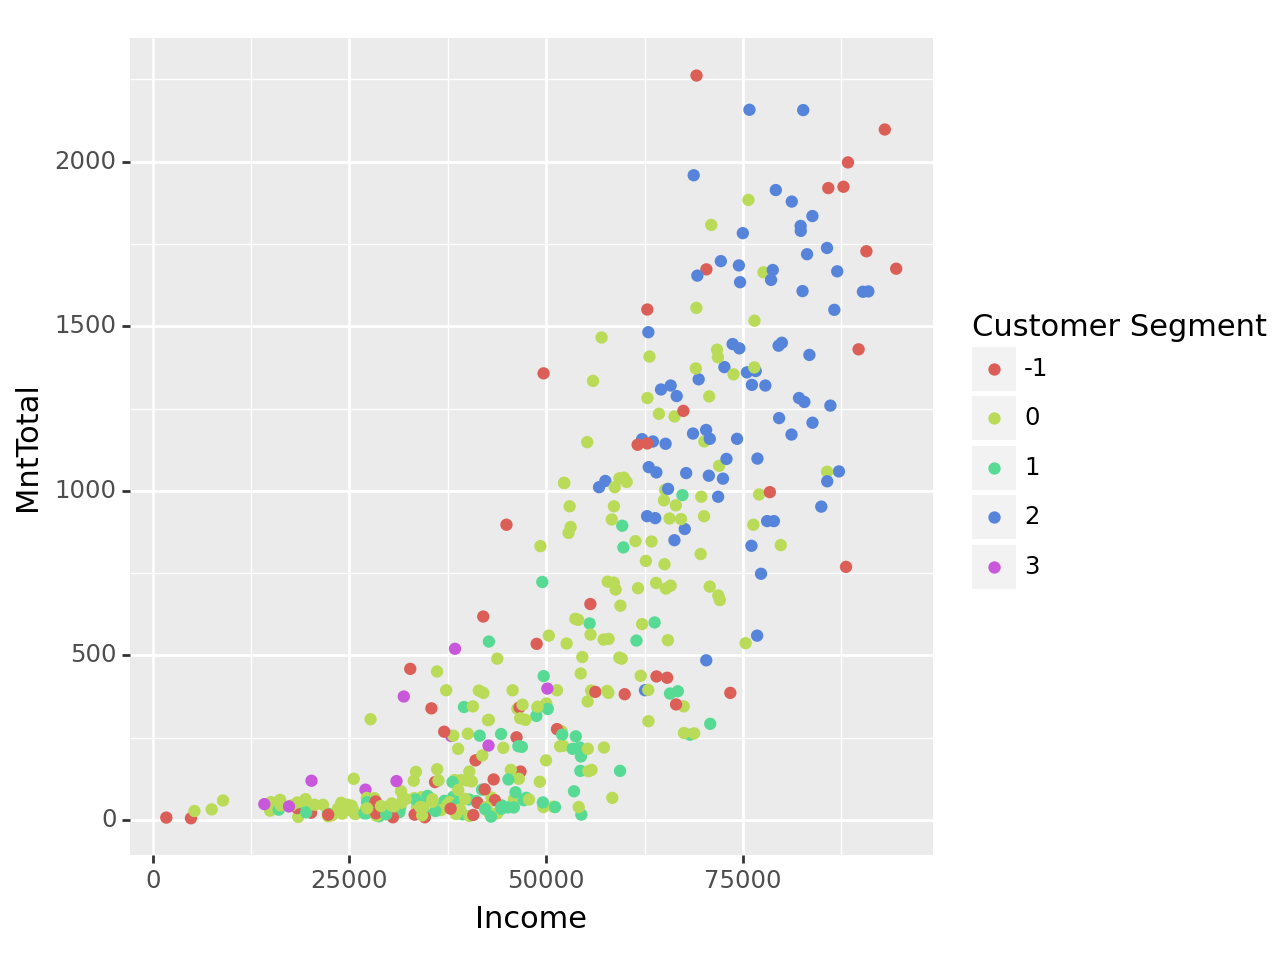

<Figure Size: (640 x 480)>

In [108]:
# @title HDBSCAN clusters
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'Income', y = 'MntTotal', color='HDBSCANPred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment")
    )

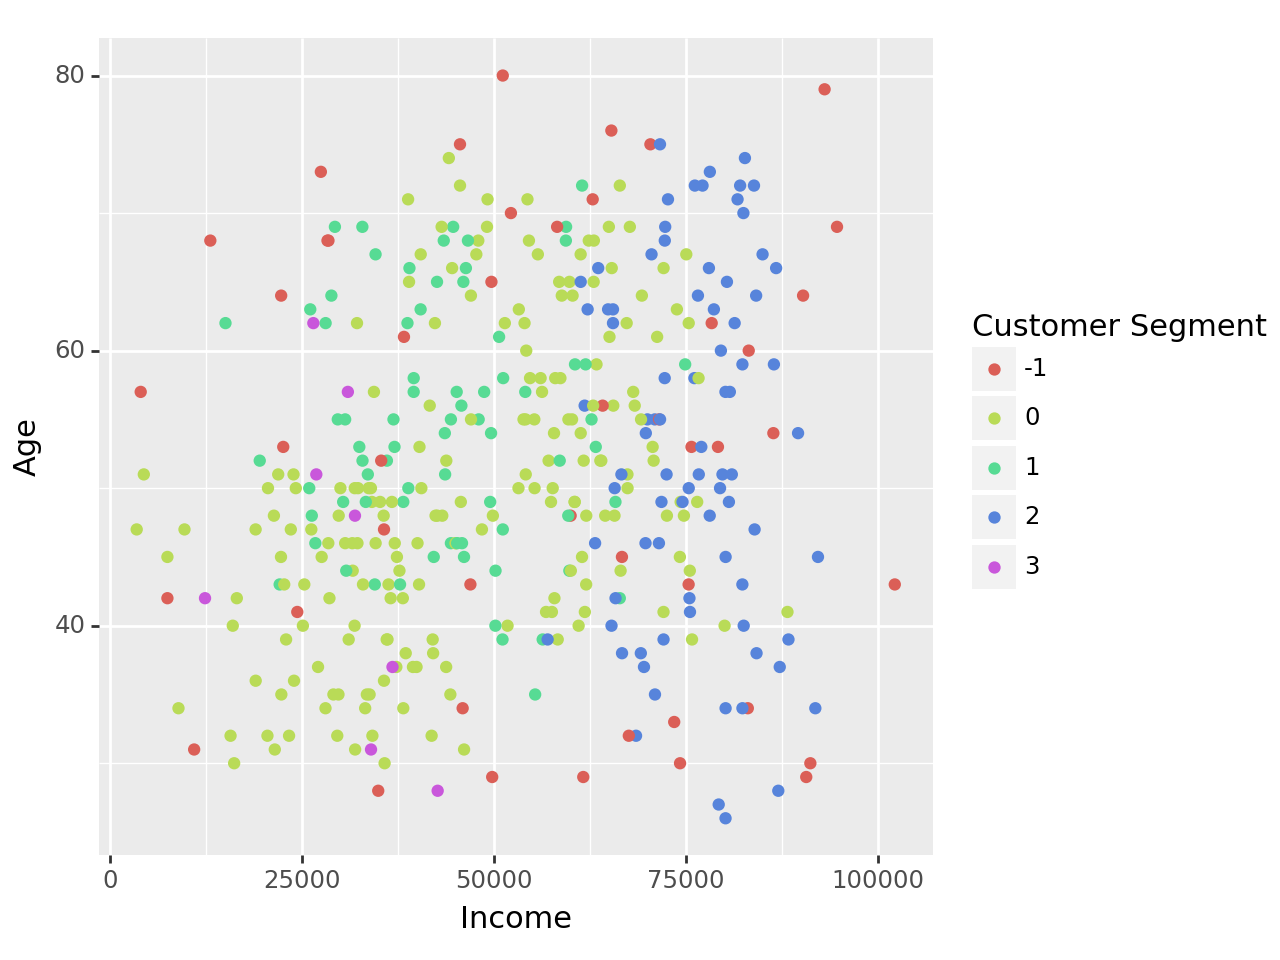

<Figure Size: (640 x 480)>

In [109]:
# @title HDBSCAN Clusters on a Age against Income Scatter Plot
(
    ggplot(data = df.sample(frac=.2), mapping=aes(x = 'Income', y = 'Age', color='HDBSCANPred')) +
    geom_point() +
    scale_colour_discrete(name="Customer Segment")
    )

# 5. Regression Analysis
---

In [110]:
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

pca = PCA(n_components=1)

X = df[campaigns].copy()

df['pca'] = pca.fit_transform(df[campaigns])


VIF measures multicollinearity in a set of regression variables. A VIF below 5 indicates little to no correlation.

In [111]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

        feature       VIF
0  AcceptedCmp1  1.357846
1  AcceptedCmp2  1.142650
2  AcceptedCmp3  1.139440
3  AcceptedCmp4  1.259607
4  AcceptedCmp5  1.440392
5      Response  1.382731


The condition index also shows the degree of multicollinearity in the matrix. It is an alternative to VIF. High condition index implies high multicollinearity/

In [112]:
correlation_matrix = X.corr()

# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(correlation_matrix)

# Calculate the condition index
condition_index = np.sqrt(max(eigenvalues) / eigenvalues)
print(f"Condition Index: {condition_index}")

Condition Index: [1.         1.34902588 1.55058337 1.90190903 1.7574112  1.80996451]


## 5.1

From the results from the previous section, multicollinearity should not be a problem for regression analyses. In the section below, I fitted GLM on various target variables and independent variables.

MntTotal is standardized as it is skewed to the right.

In [113]:
df[['MntTotal', 'MntIndex']] = StandardScaler().fit_transform(df[['MntTotal', 'MntIndex']])

In [137]:
endog = 'MntTotal ~ C(AcceptedCmp1) + C(AcceptedCmp2) + C(AcceptedCmp3) + C(AcceptedCmp4) + C(AcceptedCmp5) +C(Response) +C(Pred)'
income_model = smf.ols(endog,
                data = df).fit()
print(income_model.summary())

                            OLS Regression Results                            
Dep. Variable:               MntTotal   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     749.4
Date:                Tue, 23 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:55:36   Log-Likelihood:                -1472.0
No. Observations:                2021   AIC:                             2962.
Df Residuals:                    2012   BIC:                             3013.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9713 

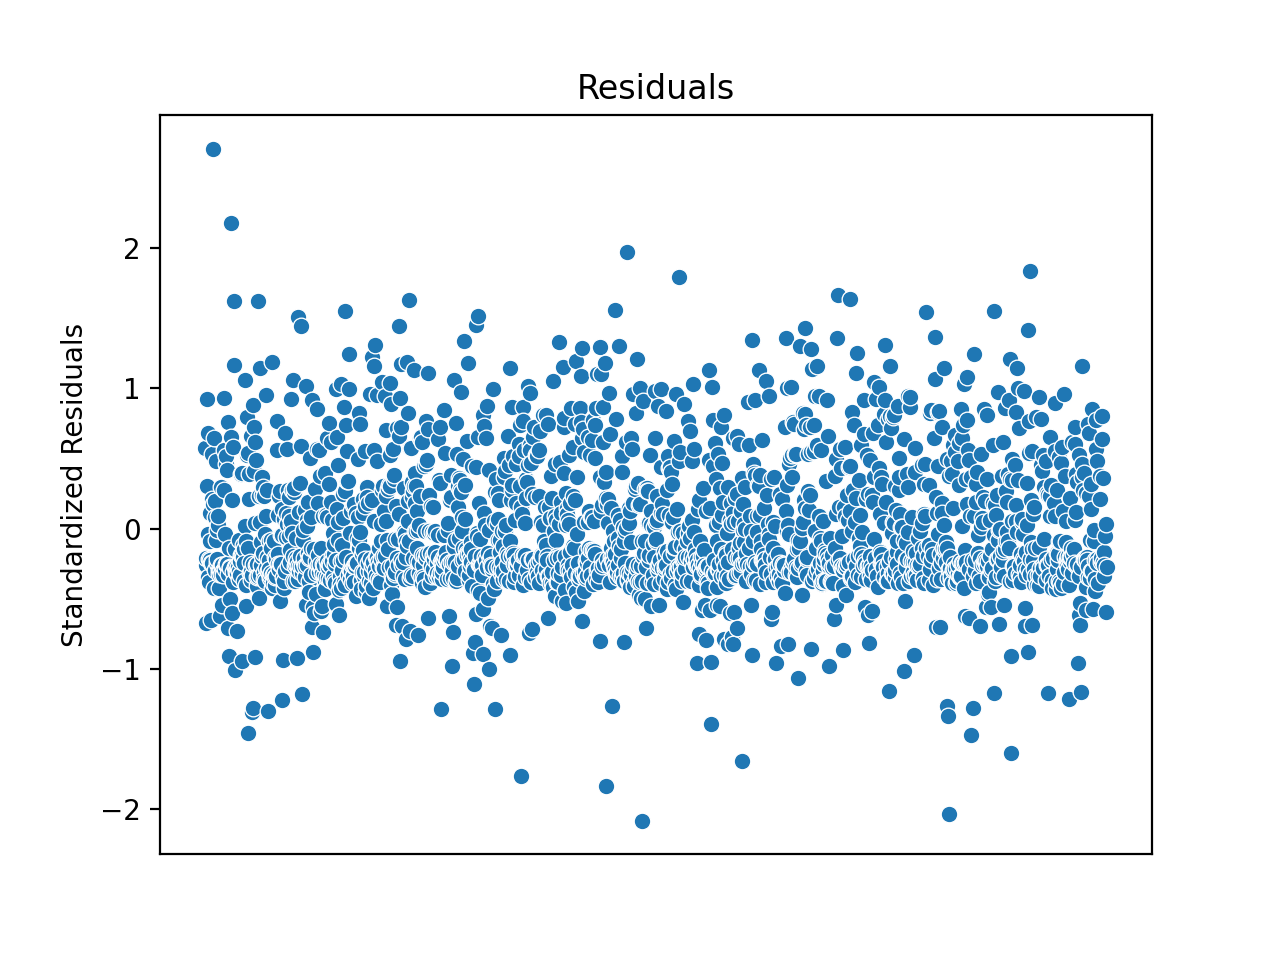

In [115]:
sns.scatterplot(data=income_model.resid)
plt.title('Residuals')
plt.ylabel('Standardized Residuals')
plt.xticks([], [])
plt.show()

In [116]:
endog = 'MntTotal ~ pca '
income_model = smf.ols(endog,
                data = df).fit()
print(income_model.summary())

                            OLS Regression Results                            
Dep. Variable:               MntTotal   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     445.7
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.46e-89
Time:                        17:38:57   Log-Likelihood:                -2666.1
No. Observations:                2021   AIC:                             5336.
Df Residuals:                    2019   BIC:                             5347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -9.289e-17      0.020  -4.61e-15      1.0

In [117]:
endog = 'Complain ~ C(AcceptedCmp1) + C(AcceptedCmp2) + C(AcceptedCmp3) + C(AcceptedCmp4) + C(AcceptedCmp5) +C(Response) + C(Pred)'

complain_model = smf.ols(endog,
                data = df).fit()
print(complain_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Complain   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6712
Date:                Tue, 23 Jul 2024   Prob (F-statistic):              0.717
Time:                        17:38:57   Log-Likelihood:                 1860.5
No. Observations:                2021   AIC:                            -3703.
Df Residuals:                    2012   BIC:                            -3652.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0068 

In [118]:
endog = 'NumCatalogPurchases ~ C(AcceptedCmp1) + C(AcceptedCmp2) + C(AcceptedCmp3) + C(AcceptedCmp4) + C(AcceptedCmp5) +C(Response)'

model = smf.ols(endog,
                data = df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     NumCatalogPurchases   R-squared:                       0.169
Model:                             OLS   Adj. R-squared:                  0.167
Method:                  Least Squares   F-statistic:                     68.30
Date:                 Tue, 23 Jul 2024   Prob (F-statistic):           1.46e-77
Time:                         17:38:58   Log-Likelihood:                -4760.2
No. Observations:                 2021   AIC:                             9534.
Df Residuals:                     2014   BIC:                             9574.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

## 5.2
Drill down on customer segments

In [140]:
endog = 'MntTotal ~ C(AcceptedCmp1) + C(AcceptedCmp2) + C(AcceptedCmp3) + C(AcceptedCmp4) + C(AcceptedCmp5) +C(Response) + Dependants'

segment1 = df[(df['Pred']=='0')]
m1 = smf.ols(endog,
                data = segment1).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               MntTotal   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     24.69
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           4.53e-30
Time:                        17:56:25   Log-Likelihood:                -657.11
No. Observations:                 687   AIC:                             1330.
Df Residuals:                     679   BIC:                             1366.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0508 

In [120]:
segment2 = df[(df['Pred']=='1')]
m2 = smf.ols(endog,
                data = segment2).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:               MntTotal   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     9.739
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           5.40e-09
Time:                        17:38:58   Log-Likelihood:                -280.73
No. Observations:                 675   AIC:                             573.5
Df Residuals:                     669   BIC:                             600.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6762 

In [121]:
segment3 = df[(df['Pred']=='2')]
m3 = smf.ols(endog,
                data = segment3).fit()
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:               MntTotal   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.582
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           4.78e-05
Time:                        17:38:58   Log-Likelihood:                -401.05
No. Observations:                 659   AIC:                             814.1
Df Residuals:                     653   BIC:                             841.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.5839 

# 6. Causal Inference
---

## Discovery
Under this section, I used Fast Casual Inference (FCI) algorithm to search for features common to observationally equivalent sets of causal directed acyclic graphs. The causal graph obtained is used to identify and estimate causal effects using DoWhy in the next section.

In [122]:
drop_list = ['Pred', 'HDBSCANPred', 'pca', 'MntIndex', 'Income']
X_df = df.drop(drop_list, axis=1)
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2021 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Kidhome               2021 non-null   int64  
 1   Teenhome              2021 non-null   int64  
 2   Recency               2021 non-null   int64  
 3   MntWines              2021 non-null   int64  
 4   MntFruits             2021 non-null   int64  
 5   MntMeatProducts       2021 non-null   int64  
 6   MntFishProducts       2021 non-null   int64  
 7   MntSweetProducts      2021 non-null   int64  
 8   MntGoldProds          2021 non-null   int64  
 9   NumDealsPurchases     2021 non-null   int64  
 10  NumWebPurchases       2021 non-null   int64  
 11  NumCatalogPurchases   2021 non-null   int64  
 12  NumStorePurchases     2021 non-null   int64  
 13  NumWebVisitsMonth     2021 non-null   int64  
 14  AcceptedCmp3          2021 non-null   int64  
 15  AcceptedCmp4          2021

In [123]:
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils

X = pd.DataFrame.to_numpy(X_df)

g, edges = fci(X)
pdy = GraphUtils.to_pydot(g)
pdy.write_png('simple_test.png')

  0%|          | 0/36 [00:00<?, ?it/s]

X1 --> X13
X5 --> X13
X8 --> X7
X12 --> X7
X11 --> X10


The causal map discovered by the FCI algorithm is shown below.

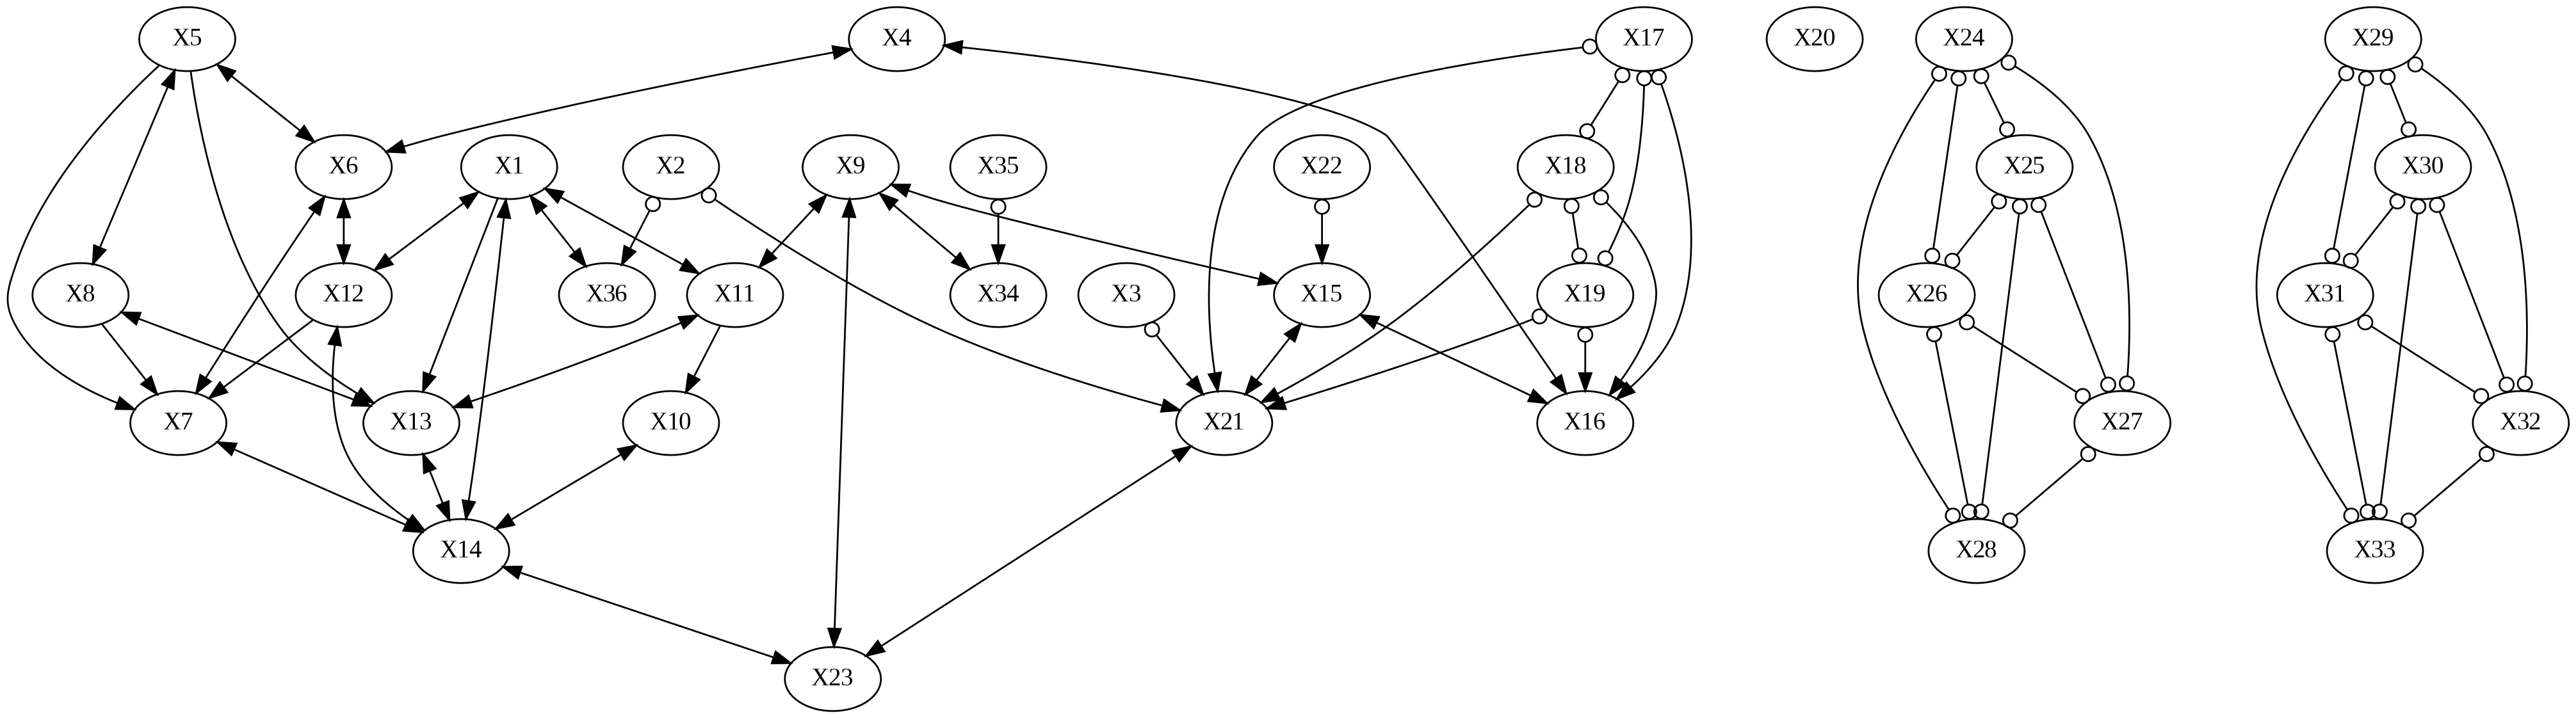

## Identification

In [124]:
from dowhy import CausalModel

In [125]:
def gToDOT(g, col_names):
  graph = str(g)

  keys = [f'X{i}' for i in range(1, len(col_names)+1)]
  col_dict = {keys[i]: col_names[i] for i in range(len(col_names))}

  for key, value in reversed(col_dict.items()):
    graph = graph.replace(key, value)

  graph_l = graph.split('\n')
  graph_l = graph_l[4:len(graph_l)-1]
  new_l = []

  for line in  graph_l:
    if '-->' in line:
      getRelation(new_l, '-->', line)

    # elif 'o->' in line:
    #   getRelation(new_l, 'o->', line)

    elif '<->' in line:
      getRelation(new_l, '<->', line)

    else:
      continue

  new_str = '\n'.join(new_l)
  DOT = f"""digraph {{
    {new_str}
    }}"""

  return DOT

def getRelation(rel_list, rel_type, line):
  relation = line.replace(rel_type, '->')
  relation = relation[3:]
  relation += ';'
  rel_list.append(relation)
  pass

In [126]:
causal_graph = gToDOT(g,X_df.columns)
causal_graph = causal_graph.replace('}', 'Response -> MntTotal;\n')
causal_graph += '}'
print(causal_graph)

digraph {
    Kidhome -> NumWebPurchases;
Kidhome -> NumCatalogPurchases;
Kidhome -> NumStorePurchases;
Kidhome -> NumWebVisitsMonth;
Kidhome -> Dependants;
MntWines -> MntMeatProducts;
 MntWines -> AcceptedCmp4;
 MntFruits -> MntMeatProducts;
 MntFruits -> MntFishProducts;
 MntFruits -> MntSweetProducts;
 MntFruits -> NumStorePurchases;
 MntMeatProducts -> MntFishProducts;
 MntMeatProducts -> NumCatalogPurchases;
 MntSweetProducts -> MntFishProducts;
 NumCatalogPurchases -> MntFishProducts;
 MntFishProducts -> NumWebVisitsMonth;
 MntSweetProducts -> NumStorePurchases;
 MntGoldProds -> NumWebPurchases;
 MntGoldProds -> AcceptedCmp3;
 MntGoldProds -> Customer_Days;
 MntGoldProds -> MntTotal;
 NumWebPurchases -> NumDealsPurchases;
 NumDealsPurchases -> NumWebVisitsMonth;
 NumWebPurchases -> NumStorePurchases;
 NumCatalogPurchases -> NumWebVisitsMonth;
 NumStorePurchases -> NumWebVisitsMonth;
 NumWebVisitsMonth -> Customer_Days;
 AcceptedCmp3 -> AcceptedCmp4;
 AcceptedCmp3 -> Response;
 R

In [127]:
model=CausalModel(
        data = X_df,
        treatment = 'Response',
        outcome = 'MntTotal',
        treatment_edges = edges,
        graph = causal_graph,
        )

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


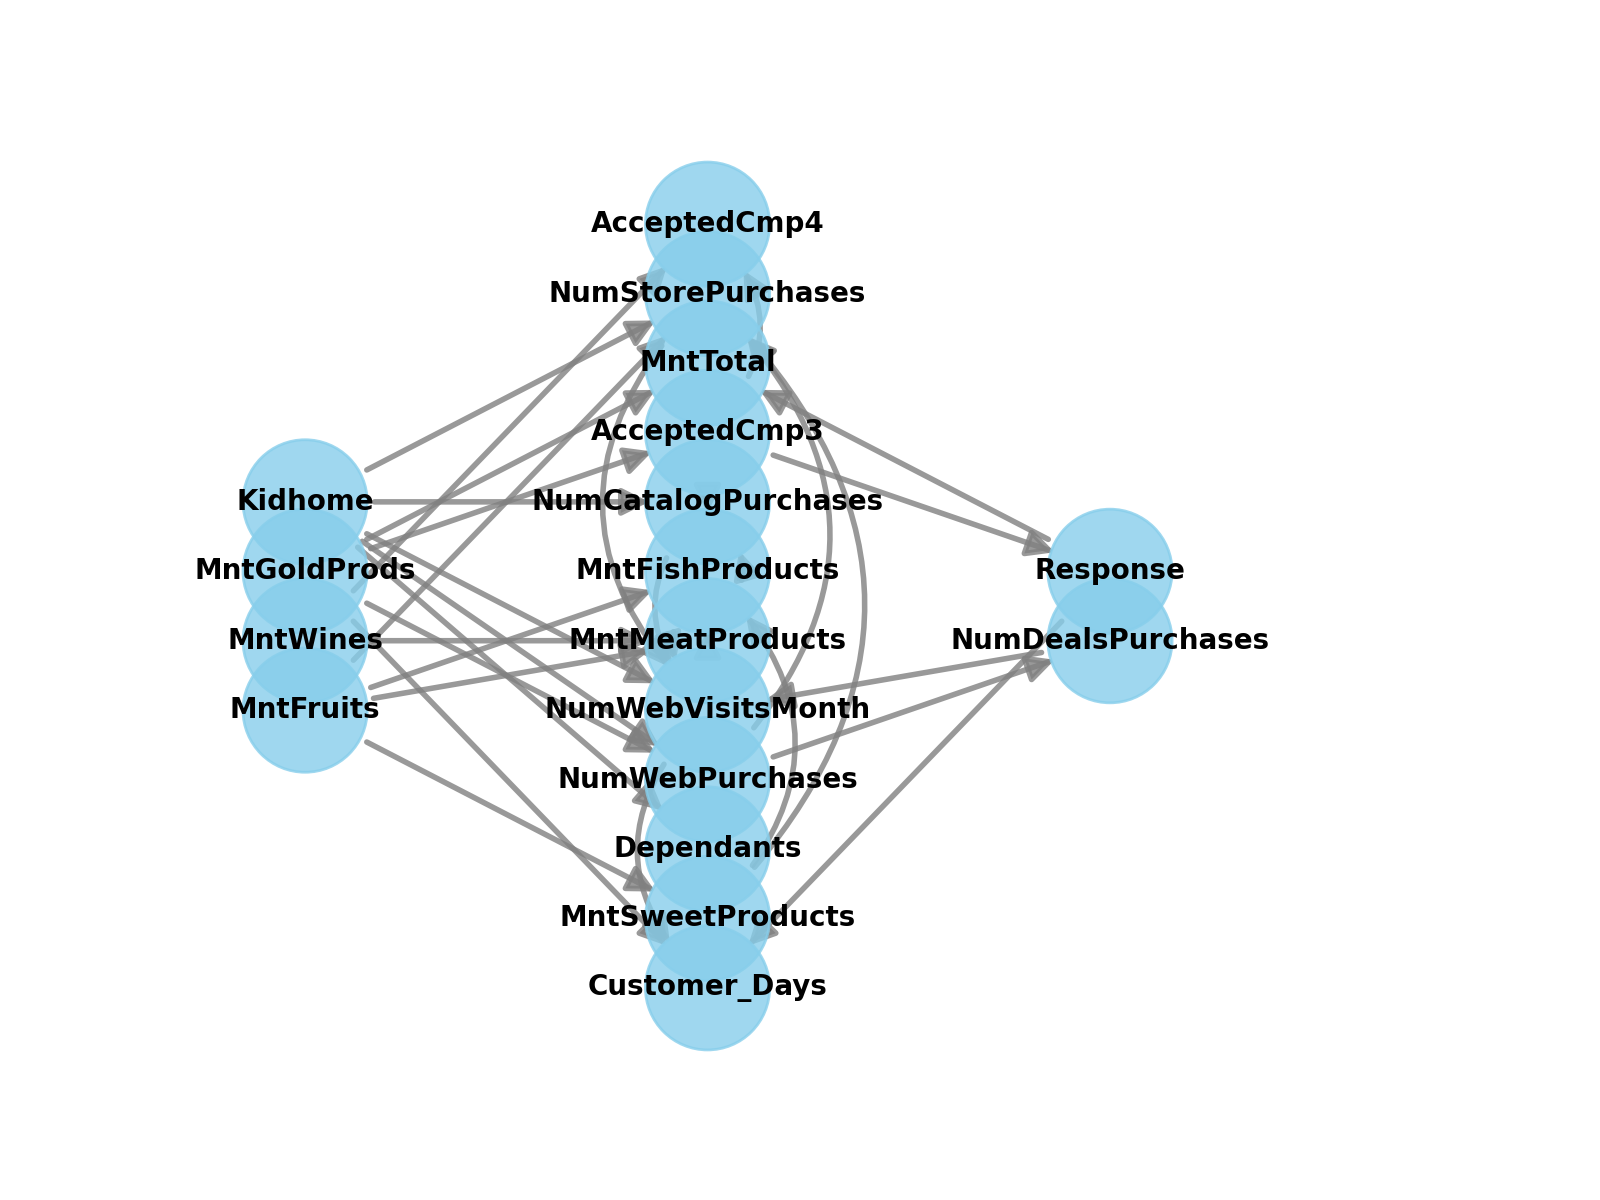

In [128]:
model.view_model()

In [129]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
───────────(E[MntTotal|MntGoldProds])
d[Response]                          
Estimand assumption 1, Unconfoundedness: If U→{Response} and U→MntTotal then P(MntTotal|Response,MntGoldProds,U) = P(MntTotal|Response,MntGoldProds)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [130]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
───────────(E[MntTotal|MntGoldProds])
d[Response]                          
Estimand assumption 1, Unconfoundedness: If U→{Response} and U→MntTotal then P(MntTotal|Response,MntGoldProds,U) = P(MntTotal|Response,MntGoldProds)

## Realized estimand
b: MntTotal~Response+MntGoldProds
Target units: ate

## Estimate
Mean value: 0.5396118213320114
p-value: [6.17397841e-23]

Causal Estimate is 0.5396118213320114


In [131]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
───────────(E[MntTotal|MntGoldProds])
d[Response]                          
Estimand assumption 1, Unconfoundedness: If U→{Response} and U→MntTotal then P(MntTotal|Response,MntGoldProds,U) = P(MntTotal|Response,MntGoldProds)

## Realized estimand
b: MntTotal~Response+MntGoldProds
Target units: ate

## Estimate
Mean value: 0.5864540629632832



In [132]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:0.5864540629632832
New effect:-0.15087127068401812
p value:0.0



In [133]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="data_subset_refuter")
print(refute_results)

Refute: Use a subset of data
Estimated effect:0.5864540629632832
New effect:0.5874596212500512
p value:0.9

